In [354]:
import os
import pandas as pd
import torch
import json
import torch.nn as nn

import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [355]:
price_folder = "data/stocknet-dataset/price/raw"
tweet_folder = "data/stocknet-dataset/tweet/preprocessed"

symbols = np.sort(os.listdir(tweet_folder))
print(symbols, len(symbols))

['AAPL' 'ABB' 'ABBV' 'AEP' 'AGFS' 'AMGN' 'AMZN' 'BA' 'BABA' 'BAC' 'BBL'
 'BCH' 'BHP' 'BP' 'BRK-A' 'BSAC' 'BUD' 'C' 'CAT' 'CELG' 'CHL' 'CHTR'
 'CMCSA' 'CODI' 'CSCO' 'CVX' 'D' 'DHR' 'DIS' 'DUK' 'EXC' 'FB' 'GD' 'GE'
 'GOOG' 'HD' 'HON' 'HRG' 'HSBC' 'IEP' 'INTC' 'JNJ' 'JPM' 'KO' 'LMT' 'MA'
 'MCD' 'MDT' 'MMM' 'MO' 'MRK' 'MSFT' 'NEE' 'NGG' 'NVS' 'ORCL' 'PCG' 'PCLN'
 'PEP' 'PFE' 'PG' 'PICO' 'PM' 'PPL' 'PTR' 'RDS-B' 'REX' 'SLB' 'SNP' 'SNY'
 'SO' 'SPLP' 'SRE' 'T' 'TM' 'TOT' 'TSM' 'UL' 'UN' 'UNH' 'UPS' 'UTX' 'V'
 'VZ' 'WFC' 'WMT' 'XOM'] 87


### Utils

In [356]:
def getDataBySymbol(symbol):
    with open(f"data/processed_data/{symbol}.json", 'r') as fp:
        data = json.load(fp)
    return data

In [203]:
def printProcessedData(symbol):
    data = getDataBySymbol(symbol)
    
    print("#" * 47)
    print("#" * 20 + " INPUT " + "#" * 20)
    print("#" * 47)
    
    for date in data["input"]:
        print(date)
        print("\t", data["input"][date]["price"])
        print("\t Tweets:")
        for tweet in data["input"][date]["tweets"]:
            print("\t\t", tweet[0], tweet[1])
    
    print("#" * 47)
    print("#" * 20 + " TARGET " + "#" * 20)
    print("#" * 47)
    
    for date in data["target"]:
        print(date, data["target"][date]["price"])

In [357]:
def visualizeProcessedData(symbol):
    data = getDataBySymbol(symbol)
    
    pi = data["input"]
    x_pi = [x for x in pi]
    y_pi = [pi[x]["price"] for x in pi]
    y2_pi = [len(pi[x]["tweets"]) for x in pi]
    
    fig = plt.figure(figsize=(20, 10))
    
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_pi, y_pi, label="price")
    ax1.set_ylabel("Price")
    
    ax2 = ax1.twinx()
    ax2.bar(x_pi, y2_pi, color='green', alpha=0.5, label="# of tweets")
    ax2.set_ylabel("# of Tweets")
    
    ax1.set_xticks(x_pi[::10])
    ax1.set_xticklabels(x_pi[::10], rotation=90)
    ax1.set_xlabel("Date")
    
    plt.legend()
    plt.title("Inputs")
    plt.show()
    
    pt = data["target"]
    x_pt = [x for x in pt]
    y_pt = [pt[x]["price"] for x in pt]
    
    plt.figure(figsize=(20, 10))
    plt.scatter(x_pt, y_pt)
    plt.xlabel("Date")
    plt.xticks(x_pt[::10], rotation=90)
    plt.ylabel("Price")
    plt.title("Targets")
    plt.show()

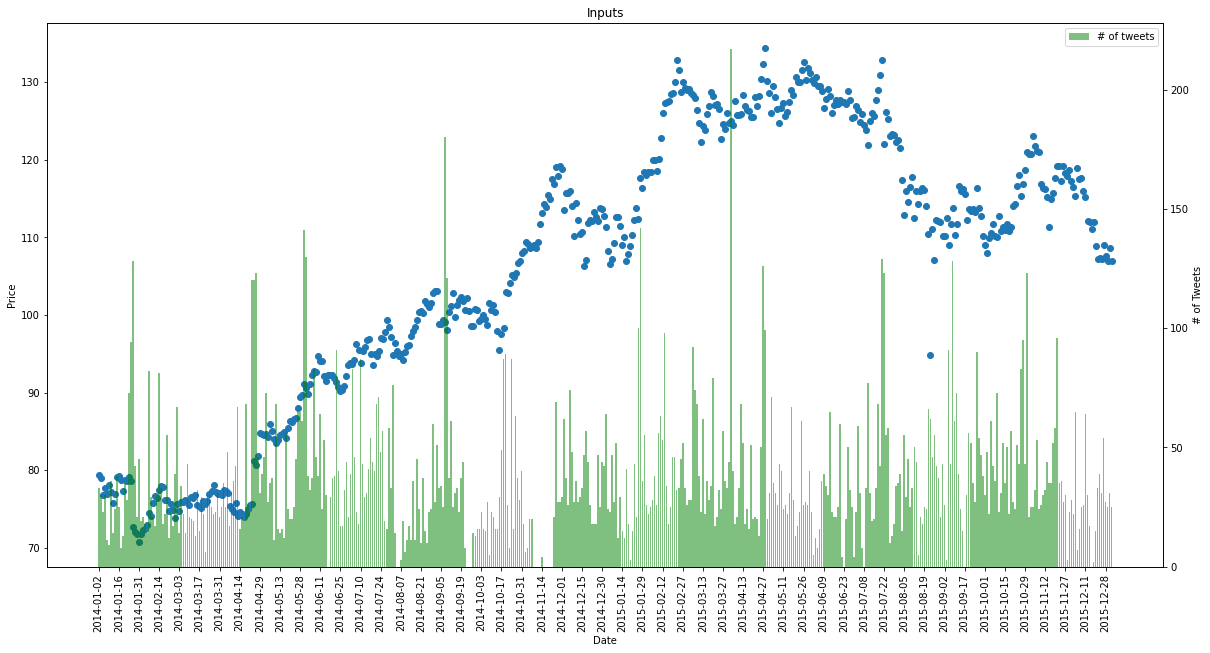

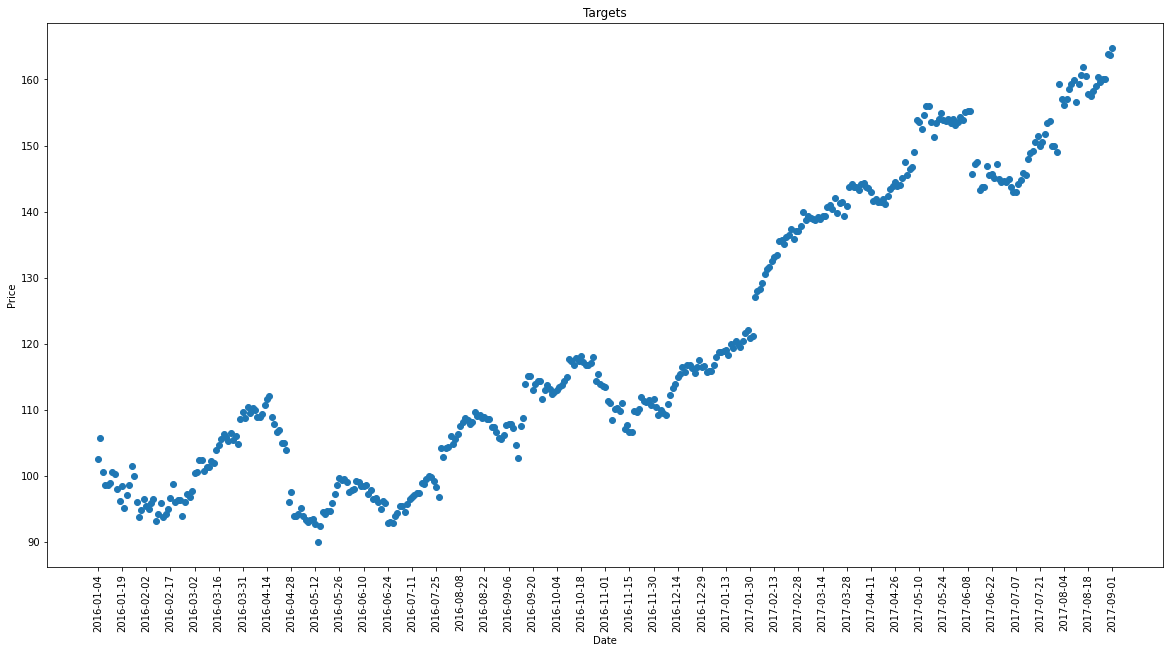

In [358]:
visualizeProcessedData("AAPL")

### Train/Val/Test Split by Symbol

In [359]:
np.random.seed(111)

In [360]:
def splitDataBySymbol():
    rand_idx = np.arange(0, 87)
    np.random.shuffle(rand_idx)

    train_symbols = symbols[rand_idx[:58]]
    val_symbols = symbols[rand_idx[58:73]]
    test_symbols = symbols[rand_idx[73:]]
    return train_symbols, val_symbols, test_symbols

In [361]:
train_symbols, val_symbols, test_symbols = splitDataBySymbol()
train_symbols = np.delete(train_symbols, -1)
print(train_symbols, "\n")
print(val_symbols, "\n")
print(test_symbols)

['UPS' 'SO' 'MSFT' 'CVX' 'TM' 'MO' 'CAT' 'D' 'LMT' 'GD' 'BSAC' 'BUD' 'MDT'
 'NEE' 'HON' 'ABBV' 'UL' 'CHL' 'PTR' 'PG' 'UNH' 'SLB' 'CODI' 'AMGN' 'PICO'
 'MCD' 'AEP' 'UTX' 'NGG' 'ABB' 'AAPL' 'DHR' 'BABA' 'ORCL' 'PCG' 'EXC' 'PM'
 'T' 'SRE' 'V' 'MMM' 'SNY' 'BCH' 'PFE' 'TOT' 'C' 'UN' 'SNP' 'PPL' 'HSBC'
 'GE' 'VZ' 'JPM' 'BAC' 'IEP' 'DUK' 'HD'] 

['CMCSA' 'KO' 'MRK' 'BP' 'AMZN' 'CSCO' 'FB' 'MA' 'TSM' 'PEP' 'HRG' 'NVS'
 'CHTR' 'GOOG' 'BRK-A'] 

['DIS' 'RDS-B' 'BBL' 'BHP' 'BA' 'PCLN' 'SPLP' 'INTC' 'REX' 'JNJ' 'CELG'
 'WMT' 'XOM' 'WFC']


### Batch Sampler

In [363]:
def sampleBatch(symbols, time_horizon):
    X_price = list()
    X_tweets = list()
    log_X_dates = list()
    
    Y_price = list()
    log_Y_dates = list()
    
    for symbol in symbols:
        this_X_price = list()
        this_X_tweets = list()
        this_log_X_dates = list()
        
        this_Y_price = list()
        this_log_Y_dates = list()
        
        data = getDataBySymbol(symbol)
        all_dates = np.sort(list(data["input"].keys()))
        try:
            possible_start_dates = all_dates[:-time_horizon]
            start_date = np.random.choice(possible_start_dates)
        except:
            print(symbol)
            print(data)
        
        idx = np.where(all_dates == start_date)[0][0]
        for _ in range(time_horizon):
            date_key = all_dates[idx]
            this_X_price.append(data["input"][date_key]["price"])
            this_X_tweets.append("\n".join([f"[{b}]" for a, b in data["input"][date_key]["tweets"]]))
            this_log_X_dates.append(date_key)
            idx += 1
        
        probe_targets = False
        for _ in range(time_horizon):
            if idx >= len(all_dates):
                probe_targets = True
            else:
                date_key = all_dates[idx]
                this_Y_price.append(data["input"][date_key]["price"])
                this_log_Y_dates.append(date_key)
                idx += 1
        
        if probe_targets:
            idx = 0
            all_dates = np.sort(list(data["target"].keys()))
            for _ in range(time_horizon - len(this_Y_price)):
                date_key = all_dates[idx]
                this_Y_price.append(data["target"][date_key]["price"])
                this_log_Y_dates.append(date_key)
                idx += 1
        
        X_price.append(np.array(this_X_price))
        X_tweets.append(this_X_tweets)
        log_X_dates.append(this_log_X_dates)
        
        Y_price.append(np.array(this_Y_price))
        log_Y_dates.append(this_log_Y_dates)
    
    X_price = np.vstack(X_price)
    Y_price = np.vstack(Y_price)
    return (X_price, X_tweets, log_X_dates), (Y_price, log_Y_dates)

In [364]:
(X_price, X_tweets, log_X_dates), (Y_price, log_Y_dates) = sampleBatch(train_symbols, 10)

### Additional Utils

In [365]:
var_map = dict()

for symbol in symbols:
    data = getDataBySymbol(symbol)
    all_prices = [data["input"][d]["price"] for d in data["input"]] + [data["target"][d]["price"] for d in data["target"]]
    var_map[symbol] = np.nanvar(all_prices)

### Modeling Utils

In [387]:
def computeFinalLoss(model, symbols, time_horizon, test_horizons):
    model.eval()
    
    mean_loss = {test_horizon: list() for test_horizon in test_horizons}
    cumulative_mean = {test_horizon: list() for test_horizon in test_horizons}
    norm_var = np.array([var_map[symbol] for symbol in symbols])
    
    for test_step in tqdm(range(700)):
        (X_price, X_tweets, _), (Y_price, _) = sampleBatch(symbols, time_horizon)

        X_price = torch.tensor(X_price).float()
        pred_Y_price = model(X_price)
        pred_Y_price = pred_Y_price.detach().numpy()
        
        for idx, test_horizon in enumerate(test_horizons):
            actual_Y_price = Y_price[:, test_horizon - 1]

            h_pred_Y_price = pred_Y_price[:, idx]

            loss = np.mean(((actual_Y_price - h_pred_Y_price) ** 2) / norm_var)
            mean_loss[test_horizon].append(loss)
            cumulative_mean[test_horizon].append(np.mean(mean_loss[test_horizon]))

        if (test_step % 100 == 0):
            plt.figure(figsize=(10, 8))
            for test_horizon in cumulative_mean:
                plt.plot(cumulative_mean[test_horizon], label=test_horizon)
            plt.legend()
            plt.show()
    
    print(f"FINAL LOSS (forecast=zero-order, time_horizon={time_horizon})")
    all_loss = dict()
    for test_horizon in mean_loss:
        all_loss[test_horizon] = np.mean(mean_loss[test_horizon])
        print(test_horizon, ":", all_loss[test_horizon])
    
    return all_loss

In [379]:
def validateModel(model, symbols, time_horizon, test_horizons):
    model.eval()
    
    mean_loss = {test_horizon: list() for test_horizon in test_horizons}
    cumulative_mean = {test_horizon: list() for test_horizon in test_horizons}
    norm_var = np.array([var_map[symbol] for symbol in symbols])
    
    for test_step in tqdm(range(300)):
        (X_price, X_tweets, _), (Y_price, _) = sampleBatch(symbols, time_horizon)

        X_price = torch.tensor(X_price).float()
        pred_Y_price = model(X_price)
        pred_Y_price = pred_Y_price.detach().numpy()
        
        for idx, test_horizon in enumerate(test_horizons):
            actual_Y_price = Y_price[:, test_horizon - 1]

            h_pred_Y_price = pred_Y_price[:, idx]

            loss = np.mean(((actual_Y_price - h_pred_Y_price) ** 2) / norm_var)
            mean_loss[test_horizon].append(loss)
            cumulative_mean[test_horizon].append(np.mean(mean_loss[test_horizon]))
    
    print(f"FINAL LOSS (forecast=zero-order, time_horizon={time_horizon})")
    all_loss = dict()
    for test_horizon in mean_loss:
        all_loss[test_horizon] = np.mean(mean_loss[test_horizon])
        print(test_horizon, ":", all_loss[test_horizon])
    
    return all_loss

In [436]:
def trainModel(model, train_losses, val_losses, best_val, optimizer, time_horizon, test_horizons, val_freq, folder_name):
    model.train()
    
    norm_var = torch.tensor([var_map[symbol] for symbol in train_symbols])
    norm_var = norm_var.repeat(len(test_horizons), 1).transpose(0, 1).float()

    for train_step in tqdm(range(5000)):
        (X_price, X_tweets, _), (Y_price, _) = sampleBatch(train_symbols, time_horizon)
        X_price, Y_price = torch.tensor(X_price).float(), torch.tensor([Y_price[:, i - 1] for i in test_horizons]).float()
        Y_price = torch.transpose(Y_price, 0, 1)
        
        pred_Y_price = model(X_price)
    
        horizon_loss = torch.mean(((Y_price - pred_Y_price) ** 2) / norm_var, 0)
        total_loss = torch.sum(horizon_loss)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_losses.append(total_loss.item())

        if (train_step % val_freq == 0): ###
            model.eval()

            all_loss = validateModel(model, val_symbols, time_horizon, test_horizons)
            cur_val = 0.0
            for test_horizon in all_loss:
                val_losses[test_horizon].append(all_loss[test_horizon])
                cur_val += all_loss[test_horizon]
            
            if cur_val < best_val[0]:
                best_val[0] = cur_val
                torch.save(model, "models/" + folder_name + "/best.ckpt")
                print(f"saved checkpoint: {cur_val}")

            model.train()

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_losses[50:]) ###
            plt.subplot(1, 2, 2)
            for symbol in test_horizons:
                plt.plot(val_losses[symbol][1:], label=symbol) ###
            plt.legend()
            plt.show()

        if (train_step % 10 == 0):
            print("Step: {}...".format(train_step),
                "Loss: {:.6f}...".format(np.mean(train_losses[-10:])))

### Method 4: Multi-Variate Linear Regression

In [447]:
class LinearModel(nn.Module):
    def __init__(self, seq_len, output_size):
        super().__init__()
        self.linear = nn.Linear(seq_len, output_size)

    def forward(self, X):
        mean = torch.mean(X, -1).unsqueeze(-1).detach()
        std = torch.std(X, -1).unsqueeze(-1).detach()
            
        X = (X - mean) / std
        out = self.linear(X)
        return out * std + mean

#### Time Horizon = 10, Test Horizons = (1, 2, 3, 5, 7, 10)

In [448]:
linear_model = LinearModel(10, 6)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(linear_model))

66


In [449]:
train_losses = list()
val_losses = {i: list() for i in [1, 2, 3, 5, 7, 10]}
best_val = [np.inf]

In [454]:
optimizer = optim.Adam(linear_model.parameters(), lr = 0.0001)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.010767037978333347
2 : 0.022029636030550262
3 : 0.029378475717638537
5 : 0.049773929640952994
7 : 0.06414232634730975
10 : 0.08869383434273653


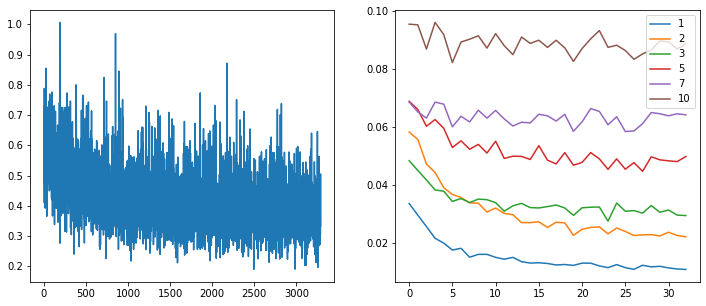

Step: 0... Loss: 0.365076...
Step: 10... Loss: 0.340931...
Step: 20... Loss: 0.378881...
Step: 30... Loss: 0.389715...
Step: 40... Loss: 0.389362...
Step: 50... Loss: 0.372384...
Step: 60... Loss: 0.364579...
Step: 70... Loss: 0.419419...
Step: 80... Loss: 0.380097...
Step: 90... Loss: 0.379426...
Step: 100... Loss: 0.421914...
Step: 110... Loss: 0.388789...
Step: 120... Loss: 0.357478...
Step: 130... Loss: 0.299418...
Step: 140... Loss: 0.399977...
Step: 150... Loss: 0.374119...
Step: 160... Loss: 0.347471...
Step: 170... Loss: 0.386566...
Step: 180... Loss: 0.433955...
Step: 190... Loss: 0.396213...
Step: 200... Loss: 0.409414...
Step: 210... Loss: 0.364374...
Step: 220... Loss: 0.332777...
Step: 230... Loss: 0.378429...
Step: 240... Loss: 0.353451...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.010371567981731094
2 : 0.021503610134262743
3 : 0.027551558118467365
5 : 0.048847107552832746
7 : 0.06199390386113856
10 : 0.08514709766928194


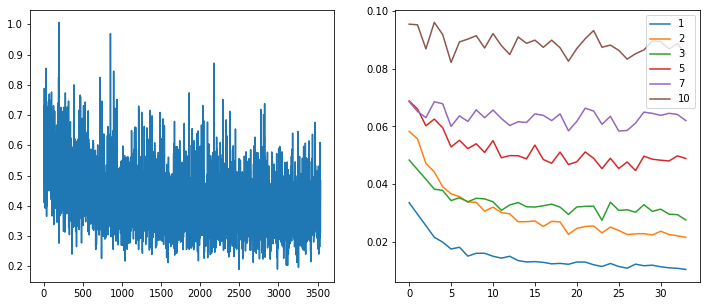

Step: 250... Loss: 0.400903...
Step: 260... Loss: 0.351678...
Step: 270... Loss: 0.368182...
Step: 280... Loss: 0.381933...
Step: 290... Loss: 0.366582...


KeyboardInterrupt: 

In [455]:
trainModel(linear_model, train_losses, val_losses, best_val, optimizer, 10, [1, 2, 3, 5, 7, 10], 250, "mvlr10")

  0%|          | 0/700 [00:00<?, ?it/s]

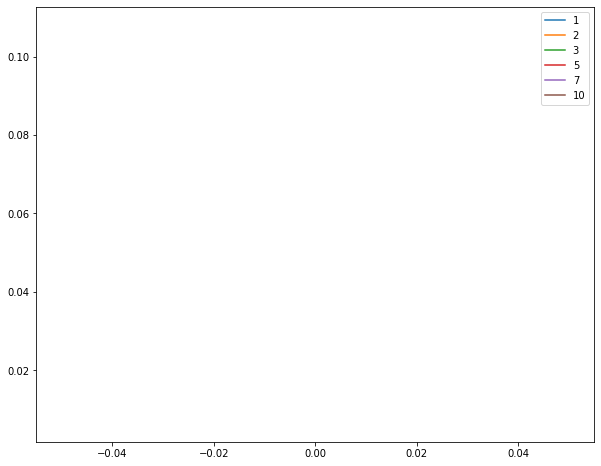

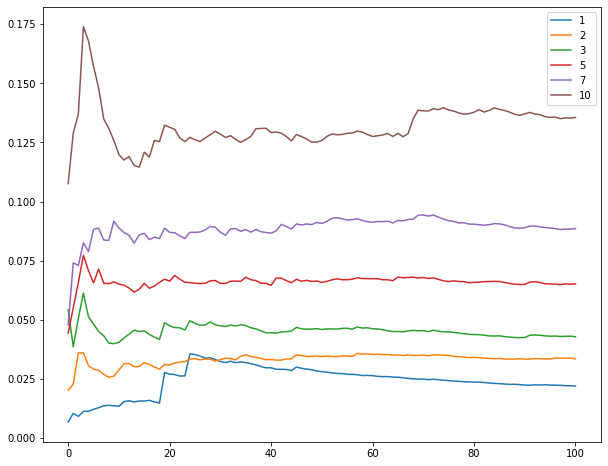

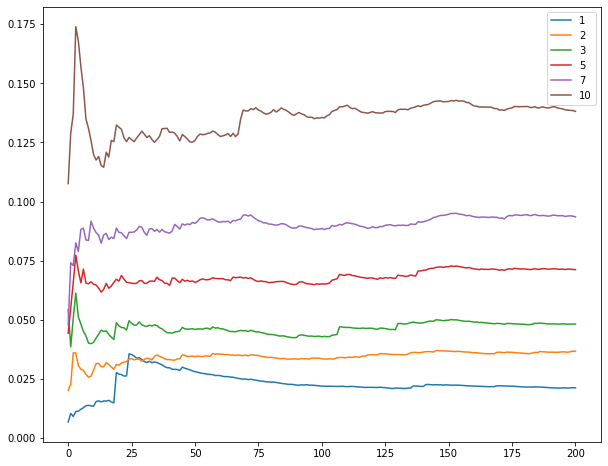

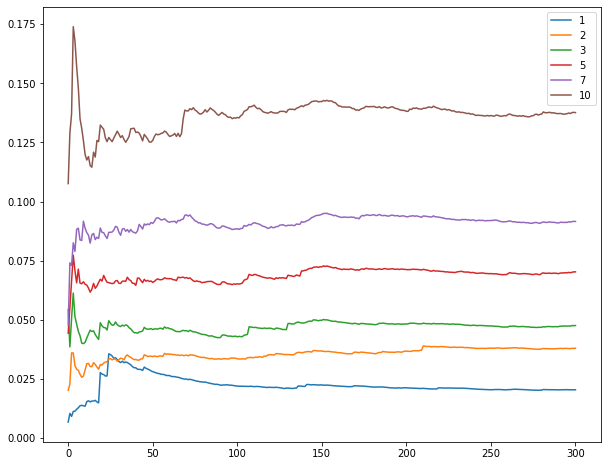

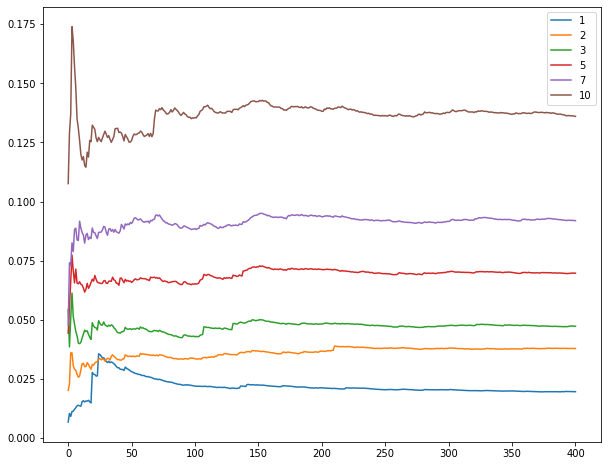

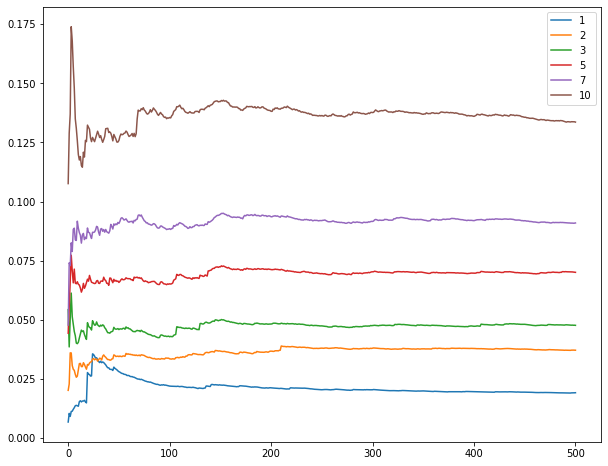

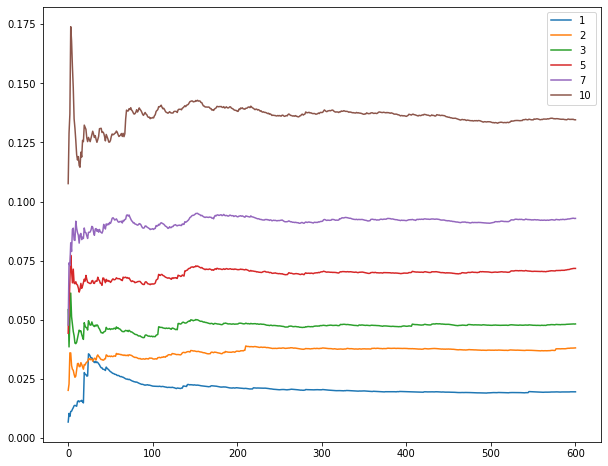

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01925455574256263
2 : 0.03907948539922239
3 : 0.04827548430756928
5 : 0.07168449250716051
7 : 0.09269123457859041
10 : 0.13323060391615307


In [456]:
linear_model = torch.load("models/mvlr10/best.ckpt")
all_loss = computeFinalLoss(linear_model, test_symbols, 10, [1, 2, 3, 5, 7, 10])

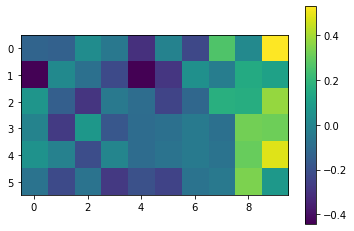

In [457]:
plt.imshow(linear_model.linear.state_dict()['weight'])
plt.colorbar()
plt.show()

#### Time Horizon = 100, Test Horizons = (1, 5, 10, 25, 50, 75, 100)

In [458]:
linear_model2 = LinearModel(100, 7)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(linear_model2))

707


In [459]:
train_losses = list()
val_losses = {i: list() for i in [1, 5, 10, 25, 50, 75, 100]}
best_val = [np.inf]

In [460]:
optimizer = optim.Adam(linear_model2.parameters(), lr = 0.001)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.13858898034769057
5 : 0.2550992507360684
10 : 0.1613226690631074
25 : 0.2043191048850171
50 : 0.3724930710998882
75 : 0.5456596656986138
100 : 0.69968862197487
saved checkpoint: 2.3771713638052554


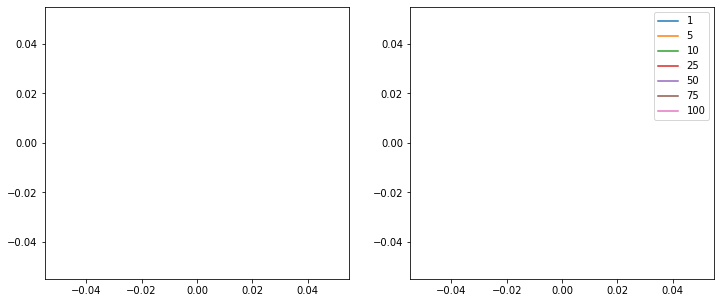

Step: 0... Loss: 3.408424...
Step: 10... Loss: 3.610600...
Step: 20... Loss: 3.165541...
Step: 30... Loss: 3.076457...
Step: 40... Loss: 3.167936...
Step: 50... Loss: 3.039935...
Step: 60... Loss: 3.088986...
Step: 70... Loss: 2.926932...
Step: 80... Loss: 2.831392...
Step: 90... Loss: 2.800837...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.0379341038276732
5 : 0.0787229543647486
10 : 0.1005959617926868
25 : 0.18902748915451312
50 : 0.2771243634953984
75 : 0.4007316111274385
100 : 0.532600069629904
saved checkpoint: 1.6167365533923626


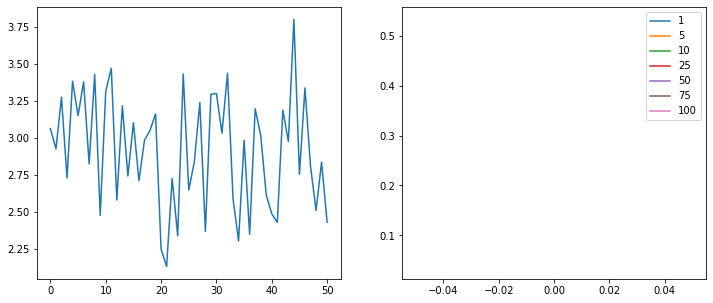

Step: 100... Loss: 2.907174...
Step: 110... Loss: 2.811617...
Step: 120... Loss: 2.790586...
Step: 130... Loss: 2.855870...
Step: 140... Loss: 2.846538...
Step: 150... Loss: 2.807255...
Step: 160... Loss: 2.673517...
Step: 170... Loss: 2.773079...
Step: 180... Loss: 2.862057...
Step: 190... Loss: 2.651294...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.030074030378684308
5 : 0.07385484559864502
10 : 0.09935041278700506
25 : 0.1840007561189168
50 : 0.289557666417312
75 : 0.41366083184304353
100 : 0.533650778618536


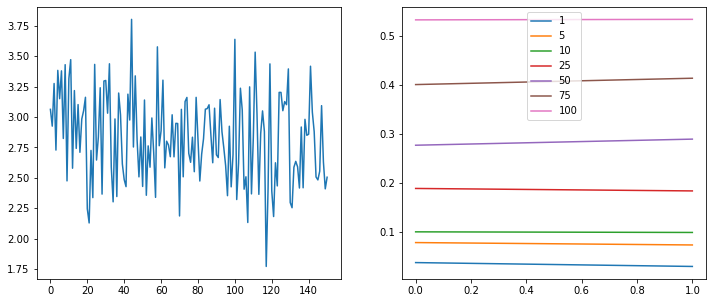

Step: 200... Loss: 2.752443...
Step: 210... Loss: 2.705262...
Step: 220... Loss: 2.776852...
Step: 230... Loss: 2.697502...
Step: 240... Loss: 2.684289...
Step: 250... Loss: 2.633533...
Step: 260... Loss: 2.656476...
Step: 270... Loss: 2.710301...
Step: 280... Loss: 2.757427...
Step: 290... Loss: 2.780890...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.024094903816176946
5 : 0.06576247035027562
10 : 0.10257032730195367
25 : 0.19406269174956886
50 : 0.2977843998194974
75 : 0.41021479316916254
100 : 0.5278569225281899


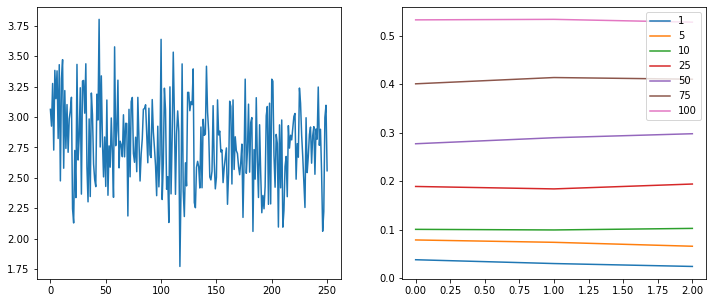

Step: 300... Loss: 2.722030...
Step: 310... Loss: 2.687320...
Step: 320... Loss: 2.762443...
Step: 330... Loss: 2.534882...
Step: 340... Loss: 2.827738...
Step: 350... Loss: 2.749517...
Step: 360... Loss: 2.659553...
Step: 370... Loss: 2.656780...
Step: 380... Loss: 2.681312...
Step: 390... Loss: 2.738655...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.020935646892341293
5 : 0.06075645905129354
10 : 0.09909968254308753
25 : 0.19578068624032816
50 : 0.2829102368463801
75 : 0.4047841152296267
100 : 0.5184160309235406
saved checkpoint: 1.582682857726598


Step: 400... Loss: 2.794579...
Step: 410... Loss: 2.814803...
Step: 420... Loss: 2.541953...
Step: 430... Loss: 2.681628...
Step: 440... Loss: 2.560555...
Step: 450... Loss: 2.636163...
Step: 460... Loss: 2.682381...
Step: 470... Loss: 2.711525...
Step: 480... Loss: 2.776649...
Step: 490... Loss: 2.625617...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.01791295291747626
5 : 0.05631384723554907
10 : 0.09074315361386834
25 : 0.18103869327268052
50 : 0.2820739182040067
75 : 0.41073136666029625
100 : 0.511197140526824
saved checkpoint: 1.550011072430701


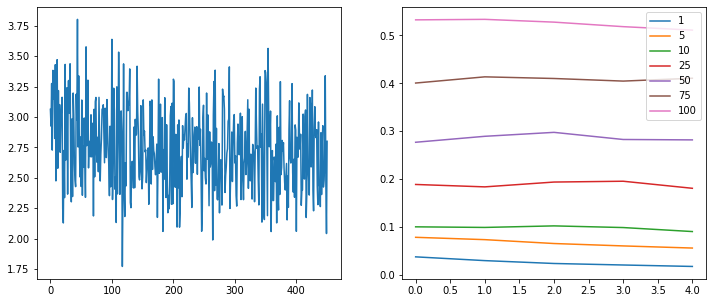

Step: 500... Loss: 2.621427...
Step: 510... Loss: 2.657039...
Step: 520... Loss: 2.876375...
Step: 530... Loss: 2.646833...
Step: 540... Loss: 2.763459...
Step: 550... Loss: 2.354770...


KeyboardInterrupt: 

In [461]:
trainModel(linear_model2, train_losses, val_losses, best_val, optimizer, 100, [1, 5, 10, 25, 50, 75, 100], 100, "mvlr100")

  0%|          | 0/700 [00:00<?, ?it/s]

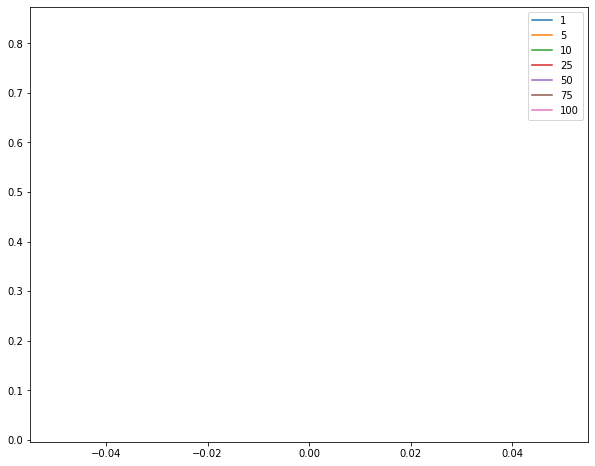

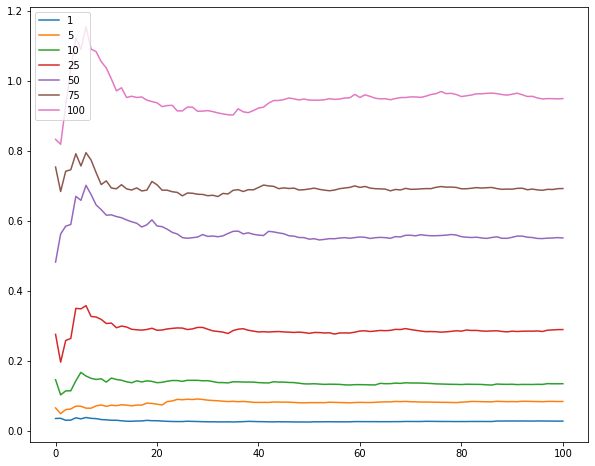

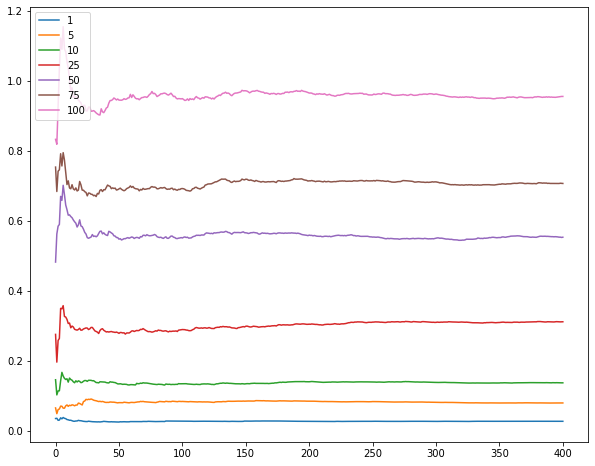

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.027993339468744324
5 : 0.07961693523508355
10 : 0.13559819180039182
25 : 0.30409359060291186
50 : 0.5516667252418134
75 : 0.7071403803405357
100 : 0.9477492265086188


In [462]:
linear_model2 = torch.load("models/mvlr100/best.ckpt")
all_loss = computeFinalLoss(linear_model2, test_symbols, 100, [1, 5, 10, 25, 50, 75, 100])

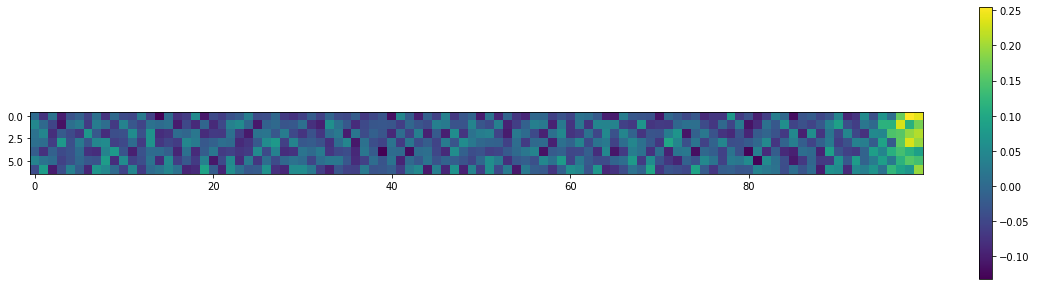

In [464]:
plt.figure(figsize=(20, 5))
plt.imshow(linear_model2.linear.state_dict()['weight'])
plt.colorbar()
plt.show()

### Method 5: FullyConnected

In [467]:
class FullyConnectedModel(nn.Module):
    def __init__(self, seq_len, d_model, output_size, dropout=0.15):
        super().__init__()
        self.d_model = d_model

        self.fc = nn.Sequential(
            nn.Linear(seq_len, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 2 * d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2 * d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_size)
        )

    def forward(self, src):
        return self.fc(src)

#### Time Horizon = 10, Test Horizons = (1, 2, 3, 5, 7, 10)

In [468]:
fc_model10 = FullyConnectedModel(10, 512, 6, 0.0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(fc_model10))

1335014


In [469]:
train_losses = list()
val_losses = {i: list() for i in [1, 2, 3, 5, 7, 10]}
best_val = [np.inf]

In [470]:
optimizer = optim.Adam(fc_model10.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 74.01412927078772
2 : 75.95966291256914
3 : 71.61898439358849
5 : 74.58256434803607
7 : 71.87258558918023
10 : 71.83977444657691
saved checkpoint: 439.8877009607386


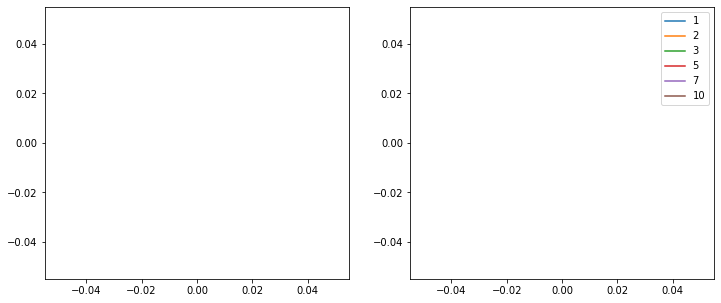

Step: 0... Loss: 573.132996...
Step: 10... Loss: 311.045219...
Step: 20... Loss: 44.517635...
Step: 30... Loss: 11.073579...
Step: 40... Loss: 4.365558...
Step: 50... Loss: 2.034924...
Step: 60... Loss: 0.981072...
Step: 70... Loss: 0.599471...
Step: 80... Loss: 0.558978...
Step: 90... Loss: 0.545842...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.036315661100228915
2 : 0.03857324546444499
3 : 0.049909095525040824
5 : 0.06157416226373818
7 : 0.07795915445688491
10 : 0.09407983712940142
saved checkpoint: 0.35841115593973927


Step: 100... Loss: 0.573287...
Step: 110... Loss: 0.508596...
Step: 120... Loss: 0.575289...
Step: 130... Loss: 0.516403...
Step: 140... Loss: 0.577956...
Step: 150... Loss: 0.564437...
Step: 160... Loss: 0.514918...
Step: 170... Loss: 0.452048...
Step: 180... Loss: 0.580299...
Step: 190... Loss: 0.610941...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.0731688784134865
2 : 0.07871697784812663
3 : 0.09702060170782349
5 : 0.10579181657701461
7 : 0.09170576144441736
10 : 0.13039338319746763


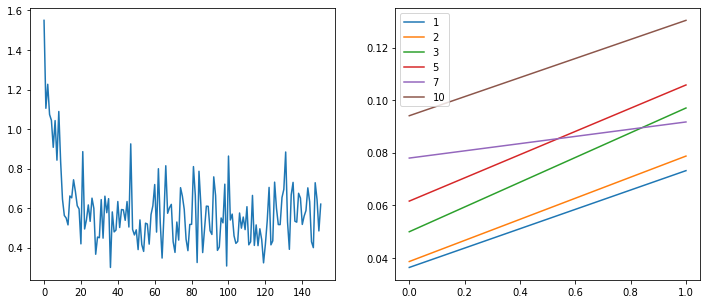

Step: 200... Loss: 0.578770...
Step: 210... Loss: 0.542903...
Step: 220... Loss: 0.454155...
Step: 230... Loss: 0.437549...
Step: 240... Loss: 0.517336...
Step: 250... Loss: 0.474466...
Step: 260... Loss: 0.475027...
Step: 270... Loss: 0.514473...
Step: 280... Loss: 0.498817...
Step: 290... Loss: 0.471878...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.03178454353475015
2 : 0.03619307020395499
3 : 0.04654886919373007
5 : 0.05767642127548207
7 : 0.07395846383326024
10 : 0.09466350782279599
saved checkpoint: 0.34082487586397353


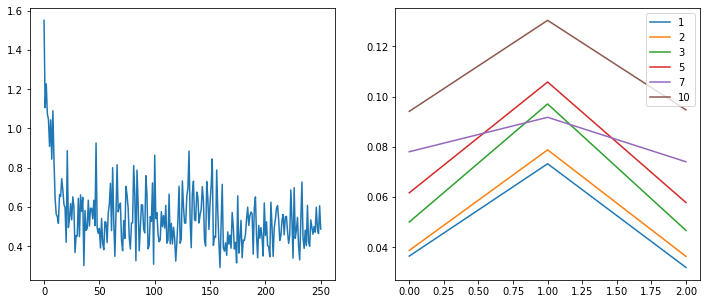

Step: 300... Loss: 0.509978...
Step: 310... Loss: 0.484836...
Step: 320... Loss: 0.584706...
Step: 330... Loss: 0.500945...
Step: 340... Loss: 0.450986...
Step: 350... Loss: 0.539316...
Step: 360... Loss: 0.545635...
Step: 370... Loss: 0.480114...
Step: 380... Loss: 0.408719...
Step: 390... Loss: 0.463442...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.023559758768231454
2 : 0.031912664068881436
3 : 0.03953791457208094
5 : 0.05476831653462089
7 : 0.07059326628761357
10 : 0.09502448684823267
saved checkpoint: 0.31539640707966093


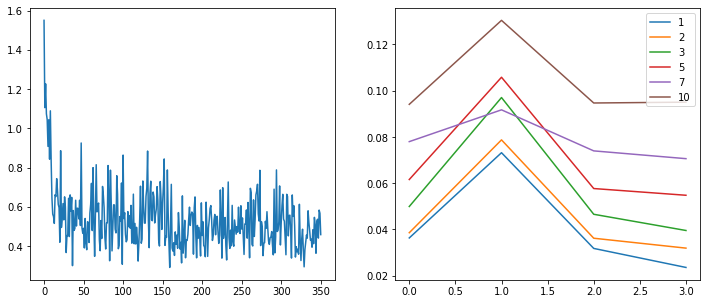

Step: 400... Loss: 0.493818...
Step: 410... Loss: 0.453777...
Step: 420... Loss: 0.464372...
Step: 430... Loss: 0.456941...
Step: 440... Loss: 0.503459...
Step: 450... Loss: 0.479529...
Step: 460... Loss: 0.510521...
Step: 470... Loss: 0.526731...
Step: 480... Loss: 0.494079...
Step: 490... Loss: 0.453516...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.025195753535642088
2 : 0.03224542605925525
3 : 0.04312594750434778
5 : 0.05699692011101627
7 : 0.06820656716555665
10 : 0.08817117286961652
saved checkpoint: 0.3139417872454346


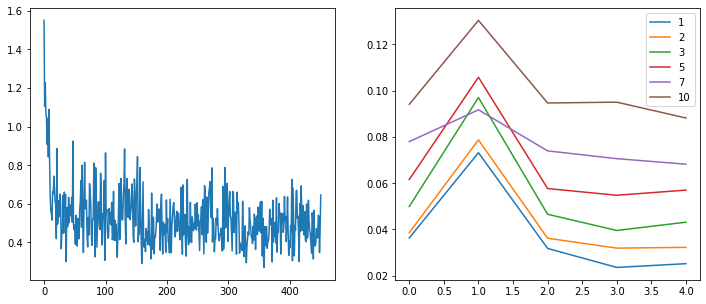

Step: 500... Loss: 0.464644...
Step: 510... Loss: 0.556574...
Step: 520... Loss: 0.446699...
Step: 530... Loss: 0.533891...
Step: 540... Loss: 0.467551...
Step: 550... Loss: 0.481556...
Step: 560... Loss: 0.471553...
Step: 570... Loss: 0.469979...
Step: 580... Loss: 0.466552...
Step: 590... Loss: 0.436239...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.029187325974600397
2 : 0.038451138467781504
3 : 0.045182056244008575
5 : 0.06247421631917464
7 : 0.06910556713014782
10 : 0.10038348504757212


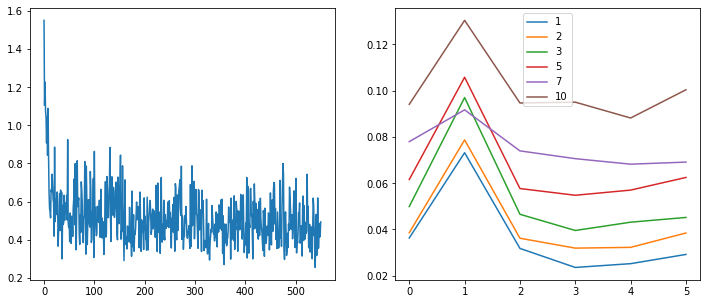

Step: 600... Loss: 0.435299...
Step: 610... Loss: 0.487331...
Step: 620... Loss: 0.471018...
Step: 630... Loss: 0.448282...
Step: 640... Loss: 0.417498...
Step: 650... Loss: 0.480183...
Step: 660... Loss: 0.493622...
Step: 670... Loss: 0.512857...
Step: 680... Loss: 0.502346...
Step: 690... Loss: 0.607802...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.015939254187285288
2 : 0.030621034516276766
3 : 0.035979279403155824
5 : 0.05446944998458972
7 : 0.06600126774223859
10 : 0.08781216945849285
saved checkpoint: 0.29082245529203904


Step: 700... Loss: 0.484907...
Step: 710... Loss: 0.419594...
Step: 720... Loss: 0.444916...
Step: 730... Loss: 0.466017...
Step: 740... Loss: 0.501311...
Step: 750... Loss: 0.432588...
Step: 760... Loss: 0.493280...
Step: 770... Loss: 0.558009...
Step: 780... Loss: 0.443632...
Step: 790... Loss: 0.465814...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.016257112890142804
2 : 0.024714667132686382
3 : 0.03400044670971097
5 : 0.05196824860283272
7 : 0.06982885427235165
10 : 0.08830623370515747
saved checkpoint: 0.285075563312882


Step: 800... Loss: 0.463654...
Step: 810... Loss: 0.427044...
Step: 820... Loss: 0.511303...
Step: 830... Loss: 0.543086...
Step: 840... Loss: 0.464254...
Step: 850... Loss: 0.414175...
Step: 860... Loss: 0.440596...
Step: 870... Loss: 0.418239...
Step: 880... Loss: 0.462832...
Step: 890... Loss: 0.402518...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.03087022505487621
2 : 0.050952934089215834
3 : 0.057816066857919735
5 : 0.09041110765265989
7 : 0.08379714098691096
10 : 0.1203785546535625


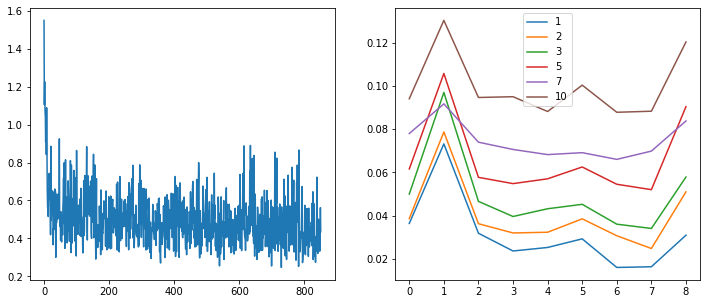

Step: 900... Loss: 0.412232...
Step: 910... Loss: 0.469968...
Step: 920... Loss: 0.511334...
Step: 930... Loss: 0.530835...
Step: 940... Loss: 0.519732...
Step: 950... Loss: 0.485166...
Step: 960... Loss: 0.373725...
Step: 970... Loss: 0.404723...
Step: 980... Loss: 0.614744...
Step: 990... Loss: 0.530426...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.11210918213389907
2 : 0.10541090779560418
3 : 0.131687229811814
5 : 0.12360105797421873
7 : 0.12486028770306822
10 : 0.15019199609139156


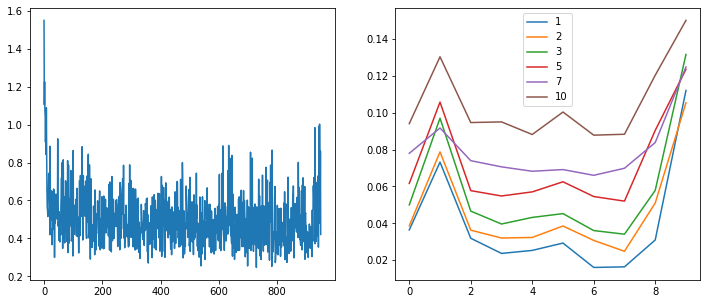

Step: 1000... Loss: 0.672276...
Step: 1010... Loss: 0.709919...


KeyboardInterrupt: 

In [471]:
trainModel(fc_model10, train_losses, val_losses, best_val, optimizer, 10, [1, 2, 3, 5, 7, 10], 100, "fc10")

  0%|          | 0/700 [00:00<?, ?it/s]

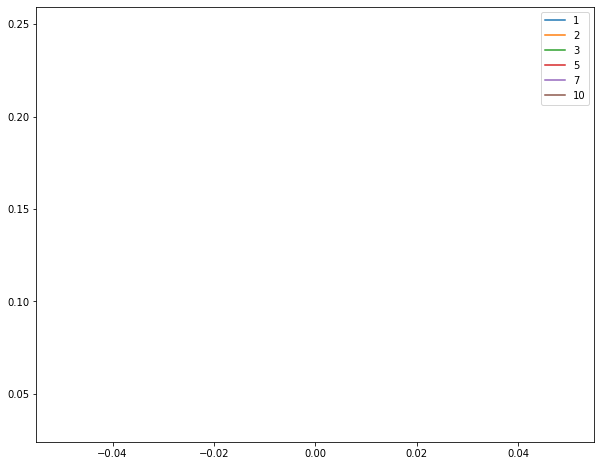

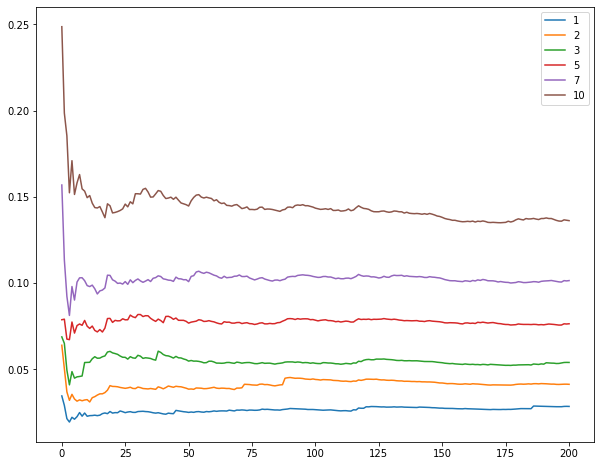

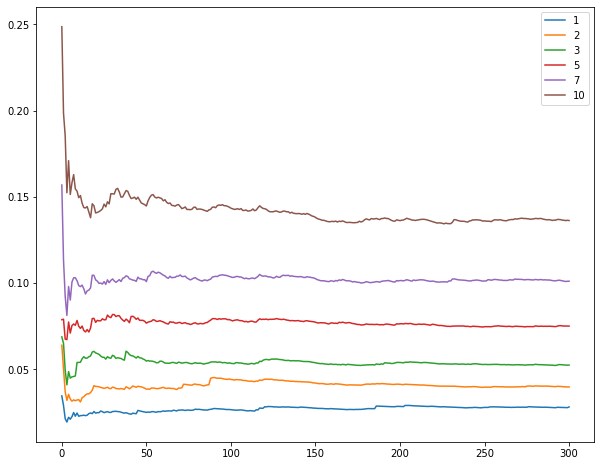

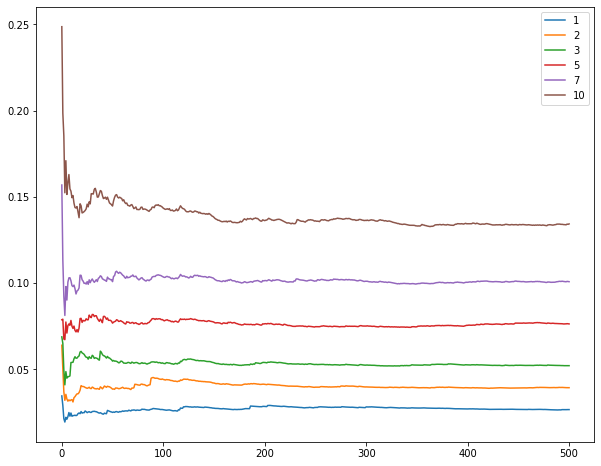

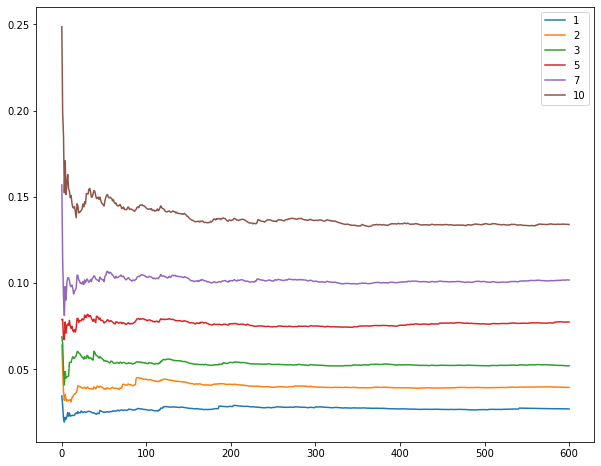

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.026232082811755028
2 : 0.039086686877536546
3 : 0.05146038196073506
5 : 0.07656893961746847
7 : 0.10060845239147746
10 : 0.13224874716670354


In [472]:
fc_model10 = torch.load("models/fc10/best.ckpt")
all_loss = computeFinalLoss(fc_model10, test_symbols, 10, [1, 2, 3, 5, 7, 10])

#### Time Horizon = 100, Test Horizons = (1, 5, 10, 25, 50, 75, 100)

In [477]:
fc_model100 = FullyConnectedModel(100, 256, 7, 0.0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(fc_model100))

363015


In [478]:
train_losses = list()
val_losses = {i: list() for i in [1, 5, 10, 25, 50, 75, 100]}
best_val = [np.inf]

In [483]:
optimizer = optim.Adam(fc_model100.parameters(), lr = 0.0001)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.07261050724432276
5 : 0.08413450972115956
10 : 0.12426750065306863
25 : 0.19191687315043887
50 : 0.2821149839408177
75 : 0.4189185821339027
100 : 0.5396556882543405
saved checkpoint: 1.7136186450980508


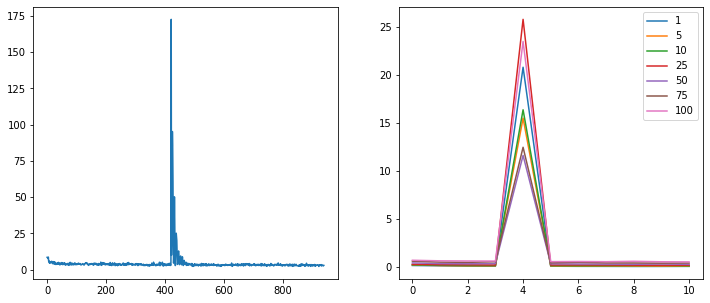

Step: 0... Loss: 2.997716...
Step: 10... Loss: 3.258849...
Step: 20... Loss: 3.069378...
Step: 30... Loss: 3.007840...
Step: 40... Loss: 2.923548...
Step: 50... Loss: 2.926858...
Step: 60... Loss: 3.091424...
Step: 70... Loss: 2.883568...
Step: 80... Loss: 3.037170...
Step: 90... Loss: 3.116588...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.07455072348850754
5 : 0.09314714779523058
10 : 0.1261218780542603
25 : 0.19376594108133482
50 : 0.3044461730700476
75 : 0.4256357080804513
100 : 0.543266363672178


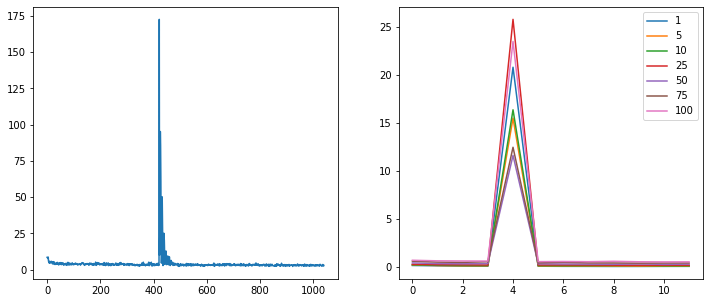

Step: 100... Loss: 2.911348...
Step: 110... Loss: 3.127190...
Step: 120... Loss: 3.152969...
Step: 130... Loss: 2.924389...
Step: 140... Loss: 2.843682...
Step: 150... Loss: 2.973568...
Step: 160... Loss: 3.136783...
Step: 170... Loss: 3.113691...
Step: 180... Loss: 2.941481...
Step: 190... Loss: 2.859808...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.07125513154199825
5 : 0.10564704773542177
10 : 0.15270787523187437
25 : 0.19223490187727185
50 : 0.30354804030283955
75 : 0.40897550557700074
100 : 0.5192259579134955


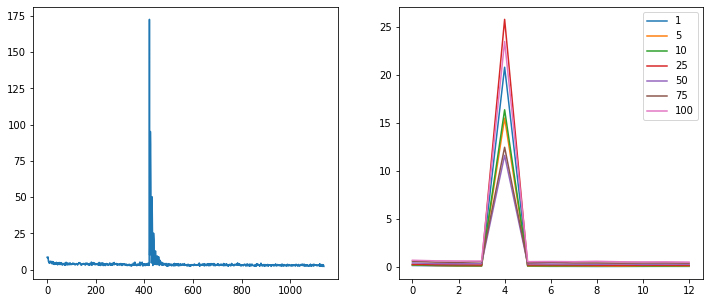

Step: 200... Loss: 2.837210...
Step: 210... Loss: 3.089286...
Step: 220... Loss: 2.962131...
Step: 230... Loss: 3.193328...
Step: 240... Loss: 3.120907...
Step: 250... Loss: 3.060621...
Step: 260... Loss: 2.979778...
Step: 270... Loss: 2.887850...
Step: 280... Loss: 3.029928...
Step: 290... Loss: 2.911954...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.055466090334828286
5 : 0.09611584742399303
10 : 0.15437146538091434
25 : 0.24004145902033183
50 : 0.3403703986013044
75 : 0.5074085992923275
100 : 0.6112545725866934


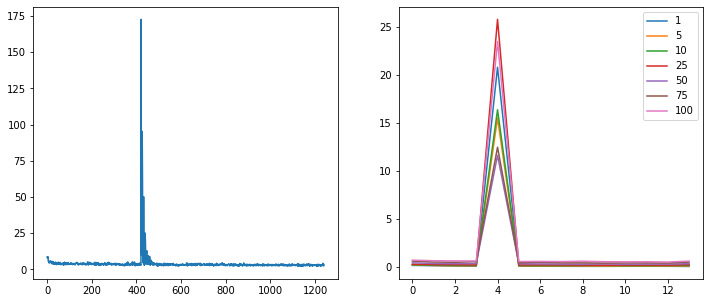

Step: 300... Loss: 3.083628...
Step: 310... Loss: 2.998470...
Step: 320... Loss: 2.795268...
Step: 330... Loss: 3.070518...
Step: 340... Loss: 2.935150...
Step: 350... Loss: 3.070759...


KeyboardInterrupt: 

In [484]:
trainModel(fc_model100, train_losses, val_losses, best_val, optimizer, 100, [1, 5, 10, 25, 50, 75, 100], 100, "fc100")

  0%|          | 0/700 [00:00<?, ?it/s]

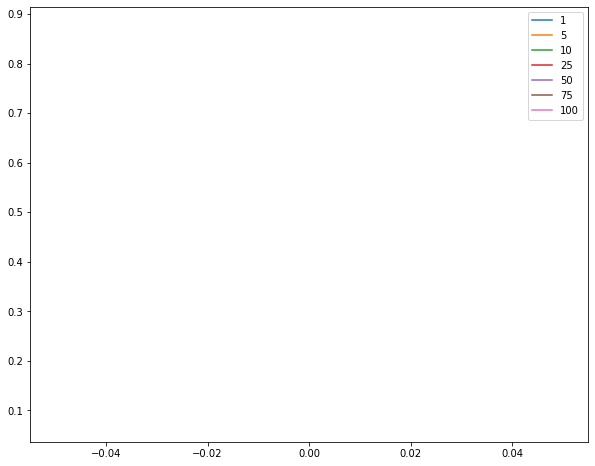

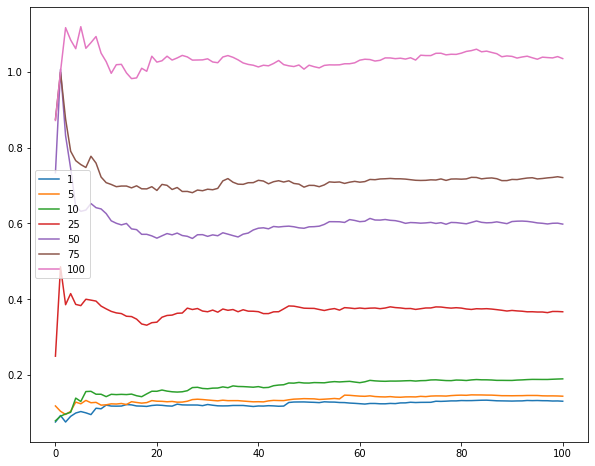

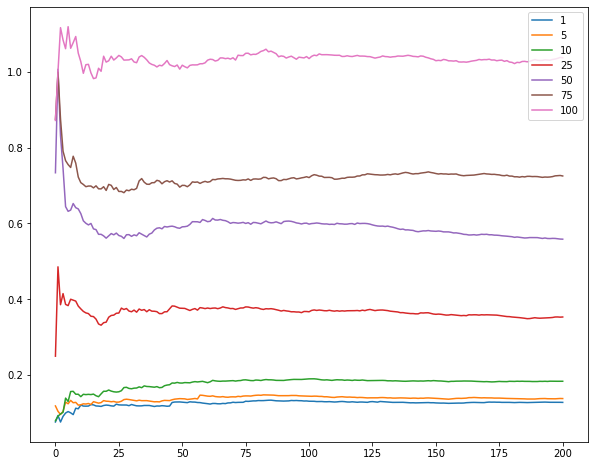

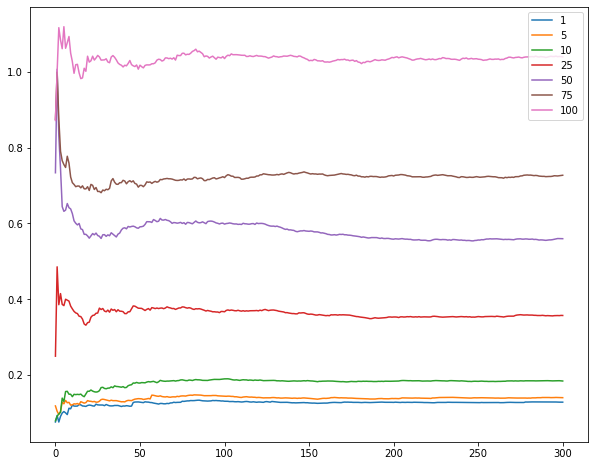

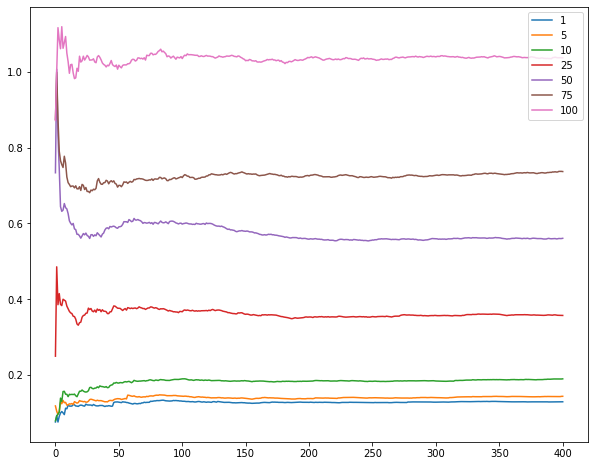

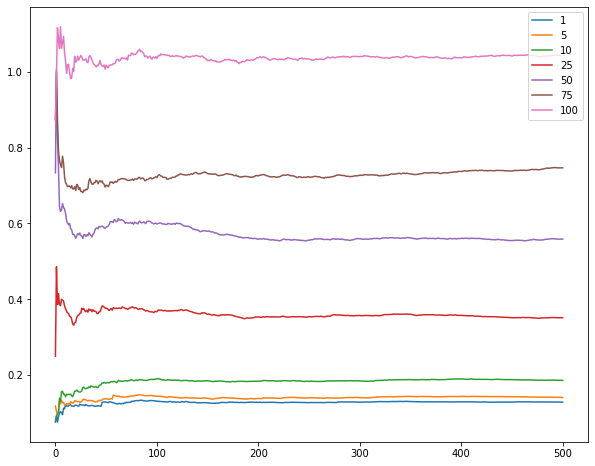

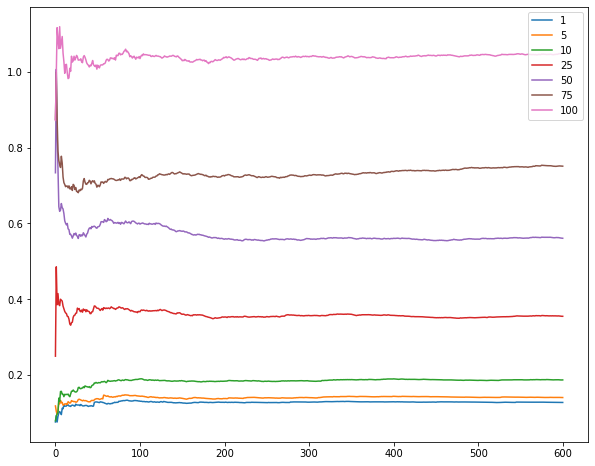

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.12838533857132547
5 : 0.14134347881238843
10 : 0.18705804180067634
25 : 0.35907565560208715
50 : 0.5625576155117623
75 : 0.7546603782670998
100 : 1.053738642821252


In [485]:
fc_model100 = torch.load("models/fc100/best.ckpt")
all_loss = computeFinalLoss(fc_model100, test_symbols, 100, [1, 5, 10, 25, 50, 75, 100])

### Method 6: LSTM

In [486]:
class LSTMModel(nn.Module):
    def __init__(self, inp_size, hidden_size, n_layers, out_size):
        super(LSTMModel, self).__init__()
        
        self.emb = nn.Linear(1, hidden_size)
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=n_layers
        )
        
        self.lin = nn.Linear(hidden_size * inp_size, out_size)

    def forward(self, X):
        mean = torch.mean(X, -1).unsqueeze(-1).detach()
        std = torch.std(X, -1).unsqueeze(-1).detach()
            
        X = (X - mean) / std
        
        emb_X = self.emb(X.unsqueeze(-1))
        out, (h, c) = self.lstm(emb_X)
        out = out.flatten(1)
        out = self.lin(out)
        
        out = out * std + mean
        return out

#### Time Horizon = 10, Test Horizons = (1, 2, 3, 5, 7, 10)

In [490]:
lstm_model10 = LSTMModel(10, 256, 2, 6)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(lstm_model10))

1068550


In [491]:
train_losses = list()
val_losses = {i: list() for i in [1, 2, 3, 5, 7, 10]}
best_val = [np.inf]

In [493]:
optimizer = optim.Adam(lstm_model10.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.032374517150266714
2 : 0.03934682281657757
3 : 0.04734326525529952
5 : 0.06071683687926234
7 : 0.07631427946579061
10 : 0.09658195884230684
saved checkpoint: 0.35267768040950365


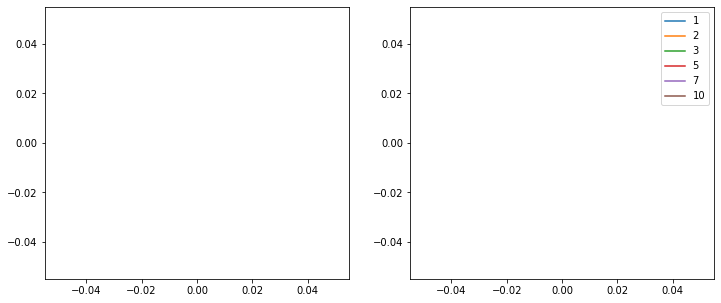

Step: 0... Loss: 0.464868...
Step: 10... Loss: 0.521090...
Step: 20... Loss: 0.446152...
Step: 30... Loss: 0.419444...
Step: 40... Loss: 0.348437...
Step: 50... Loss: 0.398175...
Step: 60... Loss: 0.359461...
Step: 70... Loss: 0.376019...
Step: 80... Loss: 0.359573...
Step: 90... Loss: 0.360398...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.012863624404176226
2 : 0.021498990442234796
3 : 0.02889848016935043
5 : 0.046875388407172994
7 : 0.060831474183425056
10 : 0.08154450259293512
saved checkpoint: 0.25251246019929463


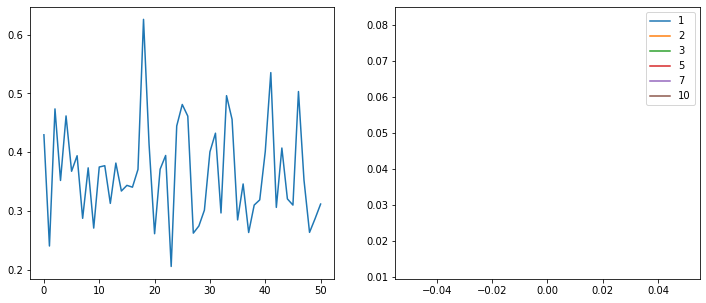

Step: 100... Loss: 0.359578...
Step: 110... Loss: 0.403477...
Step: 120... Loss: 0.380654...
Step: 130... Loss: 0.410844...
Step: 140... Loss: 0.372423...
Step: 150... Loss: 0.396499...
Step: 160... Loss: 0.383093...
Step: 170... Loss: 0.391739...
Step: 180... Loss: 0.361160...
Step: 190... Loss: 0.367802...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.010984602674220714
2 : 0.019875138892100807
3 : 0.028390489651692916
5 : 0.04889409837608201
7 : 0.06609289385741976
10 : 0.08975280008376428


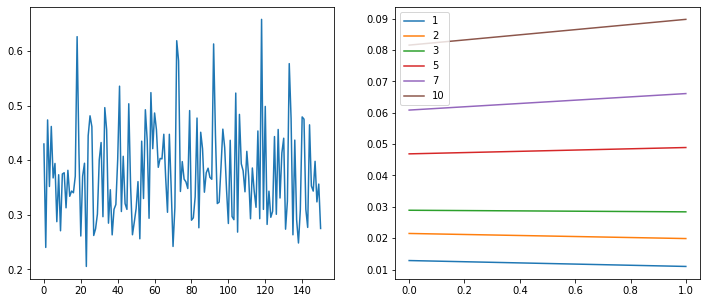

Step: 200... Loss: 0.357500...
Step: 210... Loss: 0.374142...
Step: 220... Loss: 0.362131...
Step: 230... Loss: 0.403427...
Step: 240... Loss: 0.372970...
Step: 250... Loss: 0.354950...
Step: 260... Loss: 0.358112...
Step: 270... Loss: 0.360299...
Step: 280... Loss: 0.361949...
Step: 290... Loss: 0.316997...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01049717405353002
2 : 0.019719497441944255
3 : 0.028997166288769426
5 : 0.045040314504908634
7 : 0.05987460004171164
10 : 0.0830706332862358
saved checkpoint: 0.24719938561709975


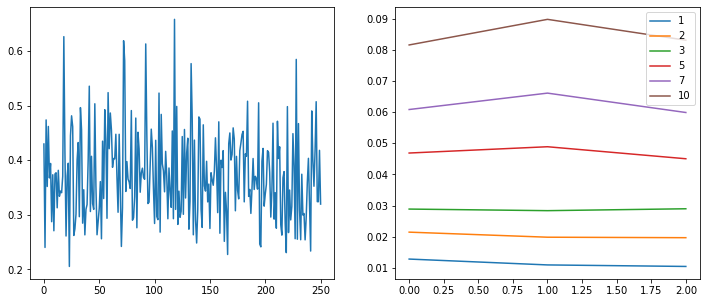

Step: 300... Loss: 0.378623...
Step: 310... Loss: 0.374440...
Step: 320... Loss: 0.336707...
Step: 330... Loss: 0.342280...
Step: 340... Loss: 0.380803...
Step: 350... Loss: 0.334195...
Step: 360... Loss: 0.336372...
Step: 370... Loss: 0.420388...
Step: 380... Loss: 0.364872...
Step: 390... Loss: 0.357388...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.010784414328802623
2 : 0.020423712872358574
3 : 0.030121246484918967
5 : 0.04811450228475768
7 : 0.06379103953162876
10 : 0.08602450922613078


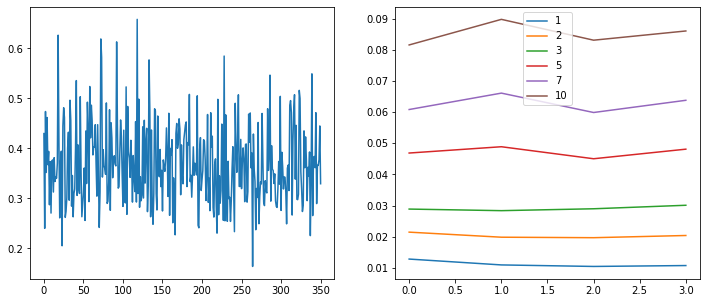

Step: 400... Loss: 0.377036...
Step: 410... Loss: 0.333207...
Step: 420... Loss: 0.351090...
Step: 430... Loss: 0.375642...
Step: 440... Loss: 0.359189...
Step: 450... Loss: 0.340847...
Step: 460... Loss: 0.300857...
Step: 470... Loss: 0.363622...
Step: 480... Loss: 0.357422...
Step: 490... Loss: 0.387930...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011628668819410139
2 : 0.02270307561855246
3 : 0.030594452753079225
5 : 0.047422618039691014
7 : 0.06270275709936603
10 : 0.08636993845231142


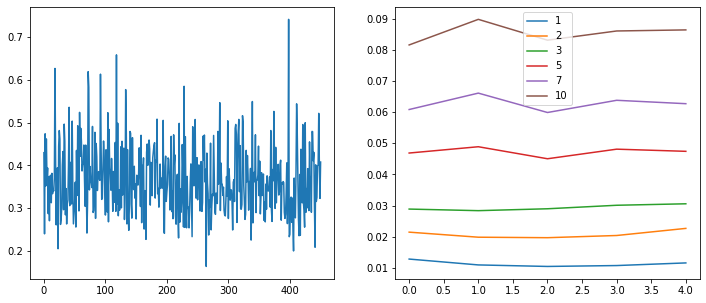

Step: 500... Loss: 0.370008...
Step: 510... Loss: 0.423738...
Step: 520... Loss: 0.339809...
Step: 530... Loss: 0.335292...
Step: 540... Loss: 0.368466...
Step: 550... Loss: 0.371575...
Step: 560... Loss: 0.335674...
Step: 570... Loss: 0.405171...
Step: 580... Loss: 0.403809...
Step: 590... Loss: 0.388799...


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [494]:
trainModel(lstm_model10, train_losses, val_losses, best_val, optimizer, 10, [1, 2, 3, 5, 7, 10], 100, "lstm10")

  0%|          | 0/700 [00:00<?, ?it/s]

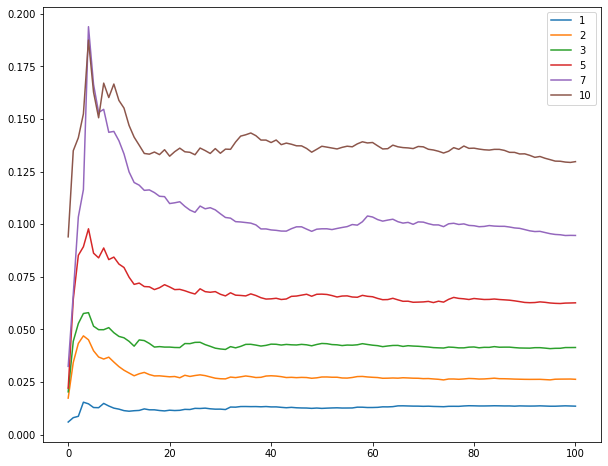

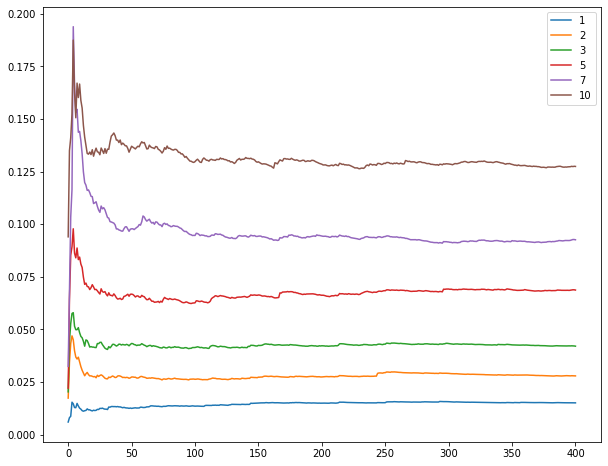

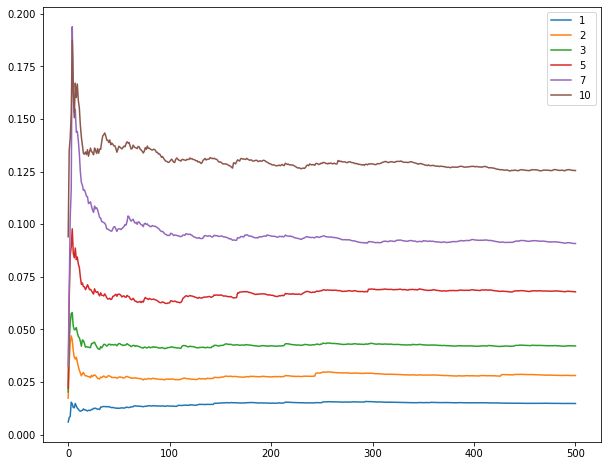

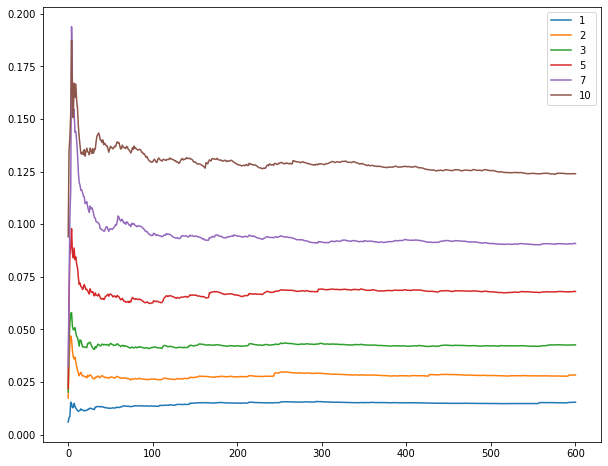

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.015534459758524903
2 : 0.02852109678145028
3 : 0.04274225637741804
5 : 0.06844773128632901
7 : 0.09169480502102902
10 : 0.12403791816995038


In [495]:
lstm_model10 = torch.load("models/lstm10/best.ckpt")
all_loss = computeFinalLoss(lstm_model10, test_symbols, 10, [1, 2, 3, 5, 7, 10])

#### Time Horizon = 100, Test Horizons = (1, 5, 10, 25, 50, 75, 100)

In [496]:
lstm_model100 = LSTMModel(100, 128, 4, 7)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(lstm_model100))

618247


In [497]:
train_losses = list()
val_losses = {i: list() for i in [1, 5, 10, 25, 50, 75, 100]}
best_val = [np.inf]

In [498]:
optimizer = optim.Adam(lstm_model100.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.16542114982881004
5 : 0.1823343513993684
10 : 0.2047054558643421
25 : 0.2765999899856263
50 : 0.4139302259628815
75 : 0.5551975575075947
100 : 0.6946346166328794
saved checkpoint: 2.4928233471815027


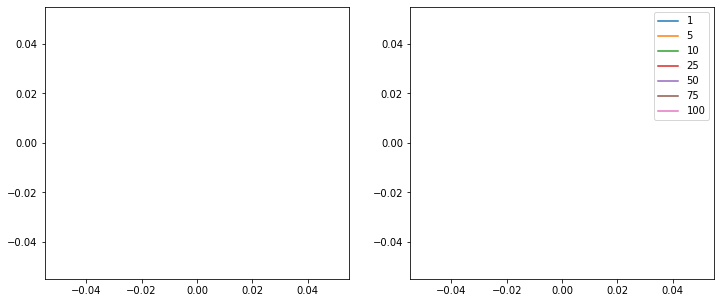

Step: 0... Loss: 4.399961...
Step: 10... Loss: 4.230734...
Step: 20... Loss: 4.142229...
Step: 30... Loss: 4.129528...
Step: 40... Loss: 4.247692...
Step: 50... Loss: 4.071898...
Step: 60... Loss: 4.015171...
Step: 70... Loss: 3.216993...
Step: 80... Loss: 3.134058...
Step: 90... Loss: 2.701835...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.049295835440451415
5 : 0.07775834336998572
10 : 0.11111625992115018
25 : 0.191571502074846
50 : 0.31028553859718644
75 : 0.4424311952389267
100 : 0.5663492213532503
saved checkpoint: 1.7488078959957964


Step: 100... Loss: 2.816345...
Step: 110... Loss: 2.908825...
Step: 120... Loss: 2.772922...
Step: 130... Loss: 2.723030...
Step: 140... Loss: 2.659710...
Step: 150... Loss: 2.713619...
Step: 160... Loss: 2.905679...
Step: 170... Loss: 2.834823...
Step: 180... Loss: 2.478398...
Step: 190... Loss: 2.598166...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.026840881502409045
5 : 0.06167049136604234
10 : 0.09713013570644494
25 : 0.17873913544217065
50 : 0.2717270073464957
75 : 0.40184711699632036
100 : 0.5287662768344212
saved checkpoint: 1.566721045194304


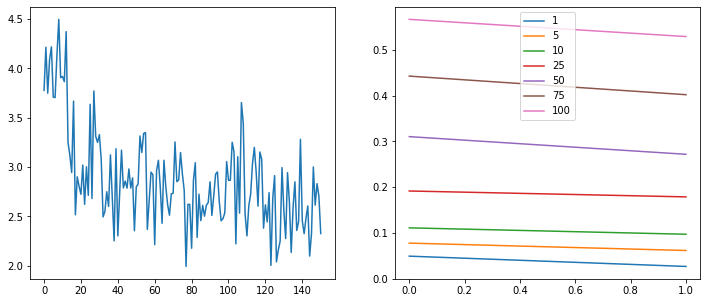

Step: 200... Loss: 2.531471...
Step: 210... Loss: 2.636059...
Step: 220... Loss: 2.451454...
Step: 230... Loss: 2.739015...
Step: 240... Loss: 2.605511...
Step: 250... Loss: 2.550107...
Step: 260... Loss: 2.644893...
Step: 270... Loss: 2.619121...
Step: 280... Loss: 2.713012...
Step: 290... Loss: 2.682997...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.022399396766874576
5 : 0.057286952333235795
10 : 0.09506325728839712
25 : 0.18969111967855562
50 : 0.27601221456433916
75 : 0.410643498927558
100 : 0.49959281042675086
saved checkpoint: 1.5506892499857112


Step: 300... Loss: 2.484814...
Step: 310... Loss: 2.676862...
Step: 320... Loss: 2.552209...
Step: 330... Loss: 2.672916...
Step: 340... Loss: 2.608172...
Step: 350... Loss: 2.756209...
Step: 360... Loss: 2.581527...
Step: 370... Loss: 2.741524...
Step: 380... Loss: 2.661595...
Step: 390... Loss: 2.651404...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.018492202089653256
5 : 0.056368427916816656
10 : 0.08802308524008472
25 : 0.17610487584328016
50 : 0.29867764279259973
75 : 0.4317841481426404
100 : 0.5289304739485823


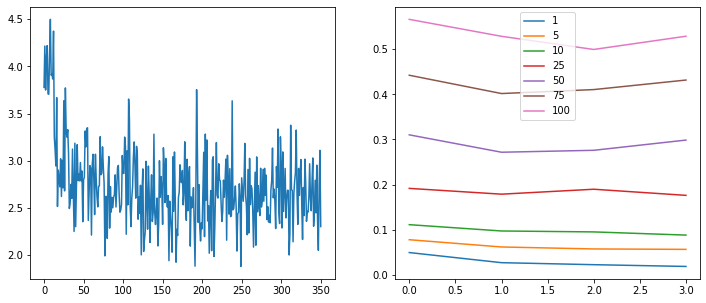

Step: 400... Loss: 2.553387...
Step: 410... Loss: 2.673898...
Step: 420... Loss: 2.521382...
Step: 430... Loss: 2.469951...
Step: 440... Loss: 2.565086...
Step: 450... Loss: 2.622480...
Step: 460... Loss: 2.612364...
Step: 470... Loss: 2.580008...
Step: 480... Loss: 2.447191...
Step: 490... Loss: 2.573556...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.01668303334250074
5 : 0.052766904071920084
10 : 0.08794807162231809
25 : 0.18737382791879867
50 : 0.2755154078251606
75 : 0.3919473982330602
100 : 0.5338709796710198
saved checkpoint: 1.5461056226847782


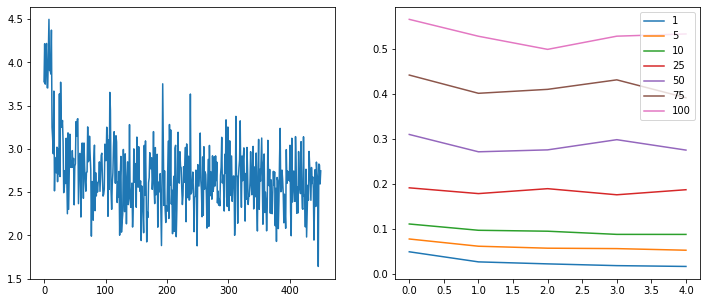

Step: 500... Loss: 2.592123...
Step: 510... Loss: 2.720622...
Step: 520... Loss: 2.638831...
Step: 530... Loss: 2.606318...
Step: 540... Loss: 2.656415...
Step: 550... Loss: 2.768219...
Step: 560... Loss: 2.382057...
Step: 570... Loss: 2.783568...
Step: 580... Loss: 2.667139...
Step: 590... Loss: 2.686236...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.01693882810849996
5 : 0.05399513508798664
10 : 0.08760932679178719
25 : 0.17928300500174435
50 : 0.29294825245400363
75 : 0.4319545963671986
100 : 0.5562666987544114


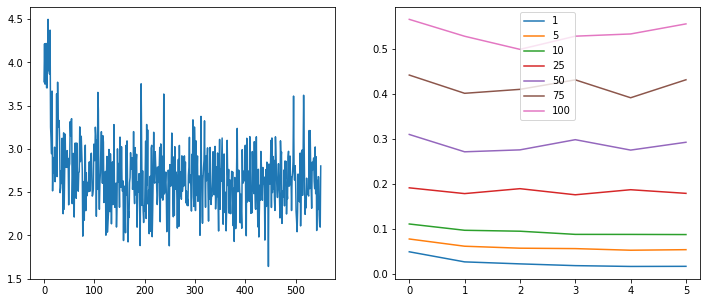

Step: 600... Loss: 2.450153...
Step: 610... Loss: 2.338487...
Step: 620... Loss: 2.433093...
Step: 630... Loss: 2.648644...
Step: 640... Loss: 2.727748...
Step: 650... Loss: 2.613701...
Step: 660... Loss: 2.669312...
Step: 670... Loss: 2.616077...
Step: 680... Loss: 2.584745...
Step: 690... Loss: 2.523190...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.016557200909804153
5 : 0.04979699949792432
10 : 0.09300421639104096
25 : 0.1935503440369404
50 : 0.3056309476729193
75 : 0.4501108821788885
100 : 0.5526563798447874


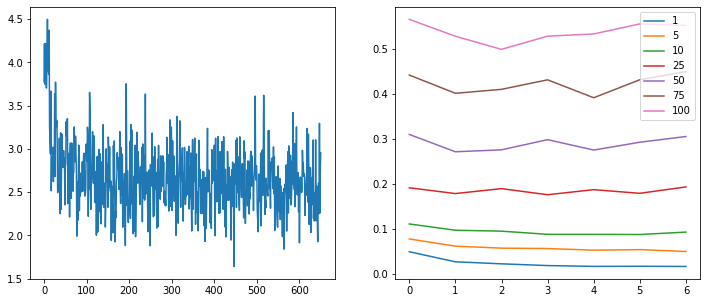

Step: 700... Loss: 2.529630...
Step: 710... Loss: 2.541293...
Step: 720... Loss: 2.693176...
Step: 730... Loss: 2.662494...
Step: 740... Loss: 2.541898...
Step: 750... Loss: 2.745429...
Step: 760... Loss: 2.610255...
Step: 770... Loss: 2.598874...
Step: 780... Loss: 2.586107...
Step: 790... Loss: 2.579458...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.015220371995227593
5 : 0.050849758003553895
10 : 0.08916738282369296
25 : 0.1849285018292074
50 : 0.2927181211682013
75 : 0.4087610893333876
100 : 0.5635138294804163


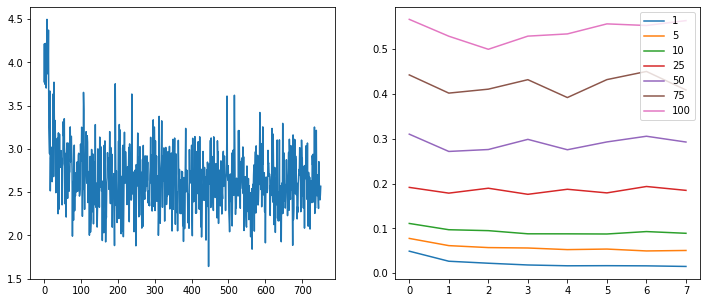

Step: 800... Loss: 2.553365...
Step: 810... Loss: 2.509237...
Step: 820... Loss: 2.603540...
Step: 830... Loss: 2.394632...
Step: 840... Loss: 2.603804...
Step: 850... Loss: 2.685145...
Step: 860... Loss: 2.759066...
Step: 870... Loss: 2.549581...
Step: 880... Loss: 2.629952...
Step: 890... Loss: 2.575378...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.018497764429319188
5 : 0.05193365134462135
10 : 0.09226094261554384
25 : 0.19018641713379844
50 : 0.3016202009427449
75 : 0.41197639835513084
100 : 0.5440187310171556


Step: 900... Loss: 2.645507...
Step: 910... Loss: 2.814955...
Step: 920... Loss: 2.698759...
Step: 930... Loss: 2.651640...
Step: 940... Loss: 2.498204...
Step: 950... Loss: 2.587238...
Step: 960... Loss: 2.879110...
Step: 970... Loss: 2.701703...
Step: 980... Loss: 2.507123...
Step: 990... Loss: 2.690822...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.013581740820823756
5 : 0.05060679274835447
10 : 0.09073999640935809
25 : 0.1790479910018245
50 : 0.2817849712775213
75 : 0.4072005043817573
100 : 0.5453214197979356


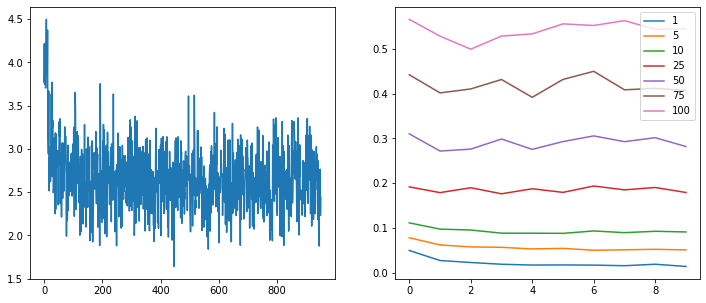

Step: 1000... Loss: 2.393030...
Step: 1010... Loss: 2.660730...
Step: 1020... Loss: 2.497927...
Step: 1030... Loss: 2.525294...
Step: 1040... Loss: 2.554752...
Step: 1050... Loss: 2.579950...
Step: 1060... Loss: 2.630380...
Step: 1070... Loss: 2.474288...
Step: 1080... Loss: 2.543984...
Step: 1090... Loss: 2.509181...


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [500]:
trainModel(lstm_model100, train_losses, val_losses, best_val, optimizer, 100, [1, 5, 10, 25, 50, 75, 100], 100, "lstm100")

  0%|          | 0/700 [00:00<?, ?it/s]

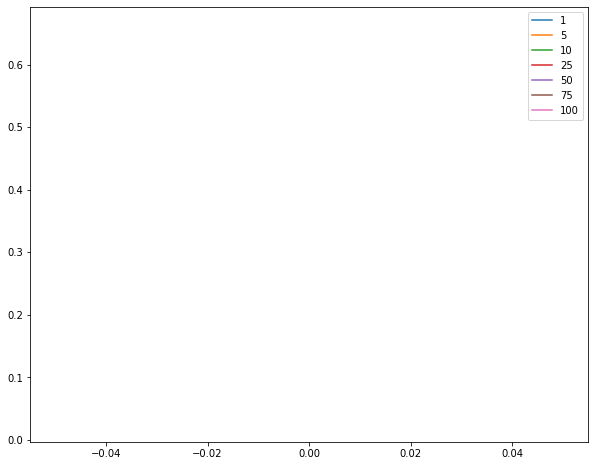

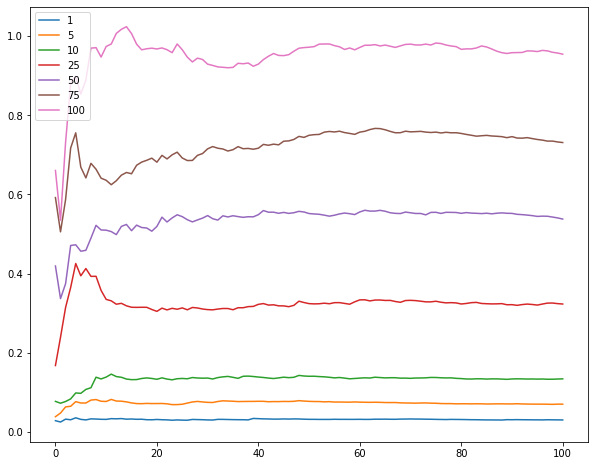

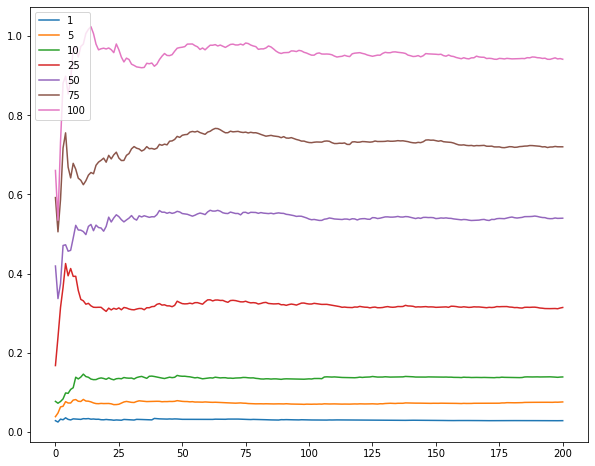

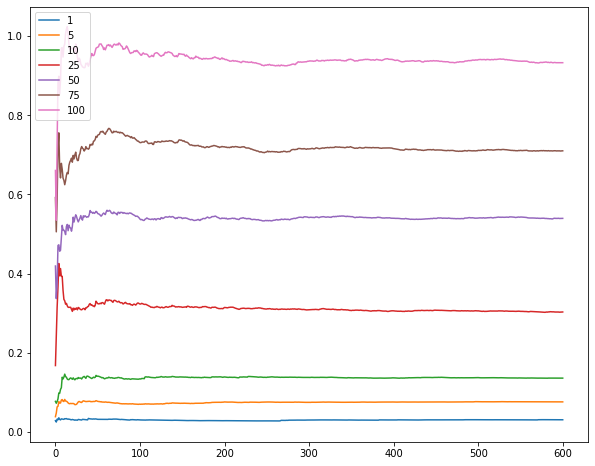

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.03054771155898515
5 : 0.0766326226056717
10 : 0.13640327956852968
25 : 0.30500599912919735
50 : 0.5456590966483134
75 : 0.7138093533917921
100 : 0.9351903134482658


In [501]:
lstm_model100 = torch.load("models/lstm100/best.ckpt")
all_loss = computeFinalLoss(lstm_model100, test_symbols, 100, [1, 5, 10, 25, 50, 75, 100])

### Method 7: Transformer

In [564]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, dropout=0.15, max_len=12):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = torch.swapaxes(x, 0, 1)
        x = x + self.pe[:x.size(0)]
        x = torch.swapaxes(x, 0, 1)
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, inp_size, out_size, d_model, n_head, d_hid, n_layers, dropout=0.15):
        super().__init__()
        self.d_model = d_model

        self.encoder = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoder(d_model, dropout, inp_size)

        encoder_layers = TransformerEncoderLayer(d_model, n_head, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)

        self.decoder = nn.Linear(d_model * inp_size, 100)
        self.fc = nn.Linear(100, out_size)

    def forward(self, X):
        mean = torch.mean(X, -1).unsqueeze(-1).detach()
        std = torch.std(X, -1).unsqueeze(-1).detach()
            
        X = (X - mean) / std
        
        enc_src = self.encoder(X.unsqueeze(-1)) * math.sqrt(self.d_model)
        pos_src = self.pos_encoder(enc_src)
        output = self.transformer_encoder(pos_src)

        out = output.reshape((X.shape[0], X.shape[1] * self.d_model))
        output2 = self.decoder(out)
        f_out = self.fc(output2)
        
        return f_out * std + mean

#### Time Horizon = 10, Test Horizons = (1, 2, 3, 5, 7, 10)

In [541]:
transformer10 = TransformerModel(10, 6, 128, 8, 128, 4)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(transformer10))

527298


In [542]:
train_losses = list()
val_losses = {i: list() for i in [1, 2, 3, 5, 7, 10]}
best_val = [np.inf]

In [543]:
optimizer = optim.Adam(transformer10.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.031234007692655417
2 : 0.0351893187525147
3 : 0.045255326960063263
5 : 0.061233907909279565
7 : 0.1338449814727057
10 : 0.0982497183380067
saved checkpoint: 0.4050072611252254


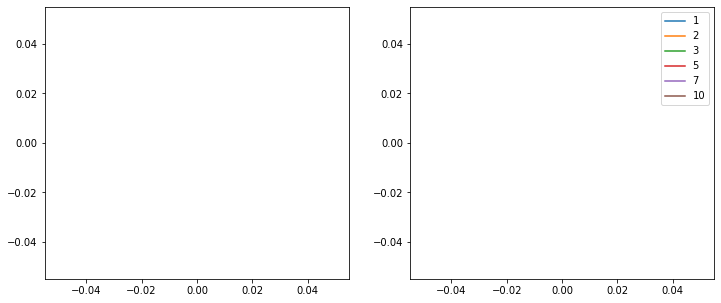

Step: 0... Loss: 0.431130...
Step: 10... Loss: 0.513171...
Step: 20... Loss: 0.418426...
Step: 30... Loss: 0.412287...
Step: 40... Loss: 0.449421...
Step: 50... Loss: 0.398126...
Step: 60... Loss: 0.386104...
Step: 70... Loss: 0.372770...
Step: 80... Loss: 0.376969...
Step: 90... Loss: 0.348497...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01163048053673326
2 : 0.02086001922154018
3 : 0.028967457378851574
5 : 0.04619089103449626
7 : 0.06141097539911854
10 : 0.08423530038847209
saved checkpoint: 0.2532951239592119


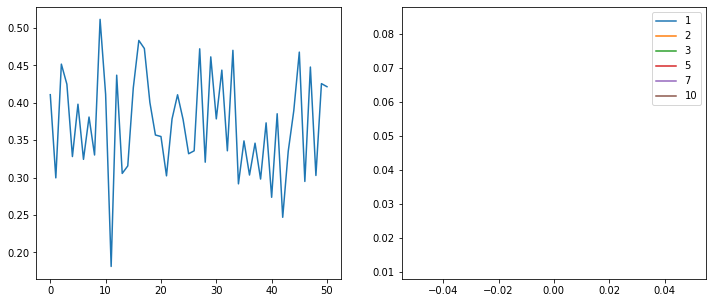

Step: 100... Loss: 0.371755...
Step: 110... Loss: 0.380522...
Step: 120... Loss: 0.360719...
Step: 130... Loss: 0.402919...
Step: 140... Loss: 0.366564...
Step: 150... Loss: 0.392362...
Step: 160... Loss: 0.424493...
Step: 170... Loss: 0.383675...
Step: 180... Loss: 0.420224...
Step: 190... Loss: 0.355362...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.011522413664700054
2 : 0.019355663710457355
3 : 0.02921295281261804
5 : 0.046283734931865037
7 : 0.06153872456391347
10 : 0.08286928284397463
saved checkpoint: 0.25078277252752856


Step: 200... Loss: 0.440668...
Step: 210... Loss: 0.385787...
Step: 220... Loss: 0.343024...
Step: 230... Loss: 0.395282...
Step: 240... Loss: 0.405388...
Step: 250... Loss: 0.396823...
Step: 260... Loss: 0.358078...
Step: 270... Loss: 0.372042...
Step: 280... Loss: 0.412610...
Step: 290... Loss: 0.383201...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.010979148209186584
2 : 0.021084117944632955
3 : 0.02858951603711842
5 : 0.0461017936319498
7 : 0.0654899774873297
10 : 0.08797056542045406


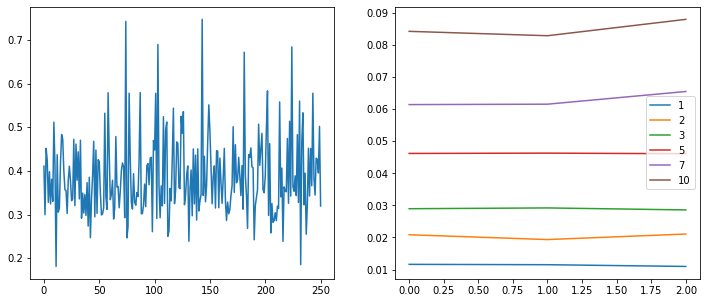

Step: 300... Loss: 0.419560...
Step: 310... Loss: 0.362083...
Step: 320... Loss: 0.338630...
Step: 330... Loss: 0.368348...
Step: 340... Loss: 0.421737...
Step: 350... Loss: 0.387848...
Step: 360... Loss: 0.326591...
Step: 370... Loss: 0.399107...
Step: 380... Loss: 0.367060...
Step: 390... Loss: 0.361746...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01180670349309726
2 : 0.022207457275439154
3 : 0.03340563631063813
5 : 0.05136130168730938
7 : 0.06646725350887073
10 : 0.08812928515707821


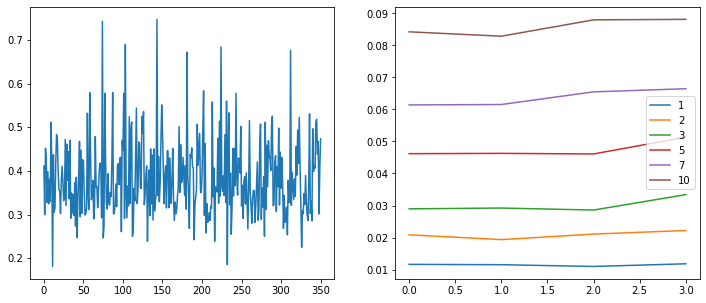

Step: 400... Loss: 0.433473...
Step: 410... Loss: 0.356755...
Step: 420... Loss: 0.340776...
Step: 430... Loss: 0.385906...
Step: 440... Loss: 0.442380...
Step: 450... Loss: 0.414170...
Step: 460... Loss: 0.383555...
Step: 470... Loss: 0.377740...
Step: 480... Loss: 0.314299...
Step: 490... Loss: 0.401252...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01266877149790082
2 : 0.020129557761694297
3 : 0.028615854055914294
5 : 0.044185832292201056
7 : 0.06217302637928783
10 : 0.08829342623959734


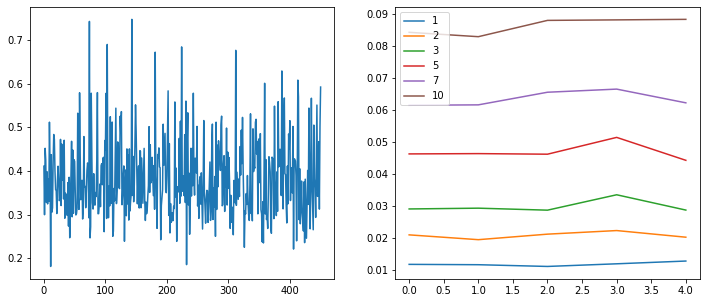

Step: 500... Loss: 0.420774...
Step: 510... Loss: 0.362990...
Step: 520... Loss: 0.390169...


KeyboardInterrupt: 

In [544]:
trainModel(transformer10, train_losses, val_losses, best_val, optimizer, 10, [1, 2, 3, 5, 7, 10], 100, "transformer10")

  0%|          | 0/700 [00:00<?, ?it/s]

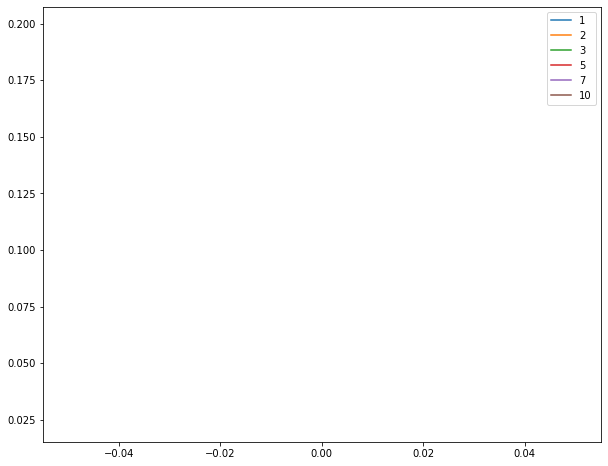

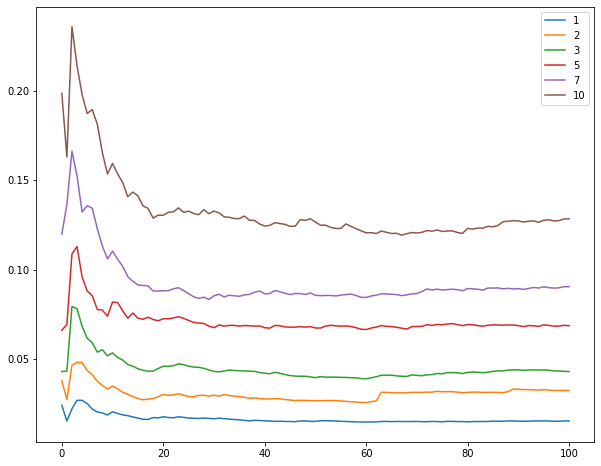

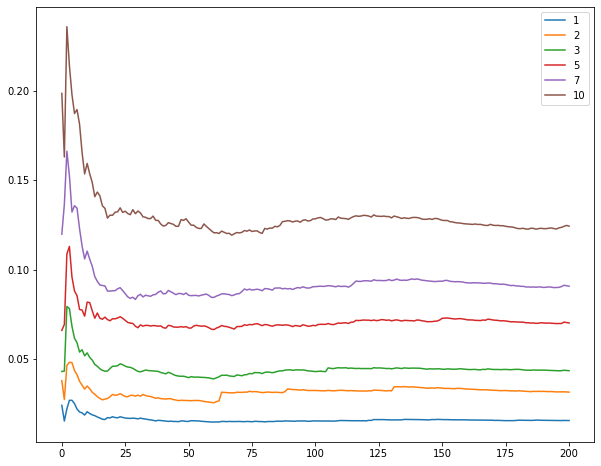

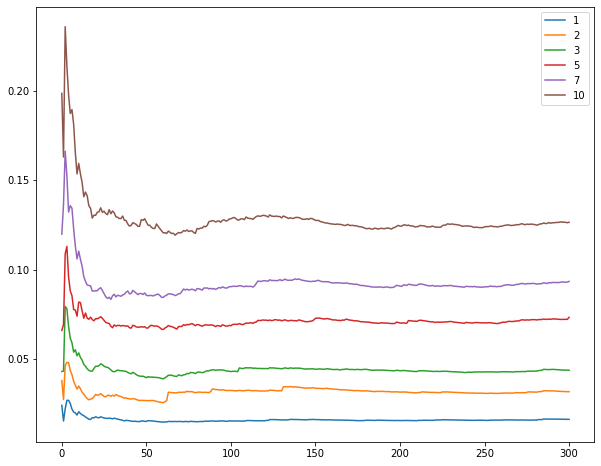

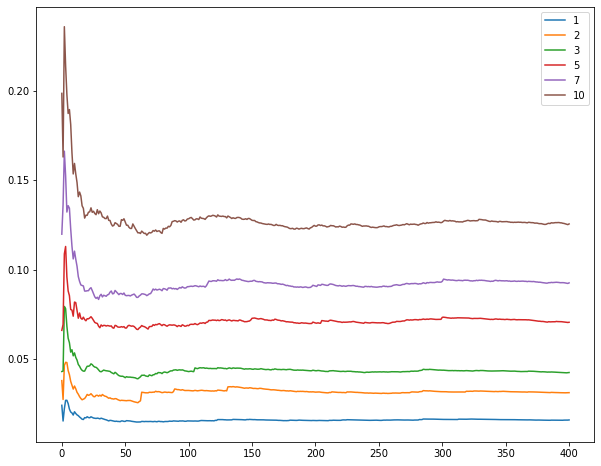

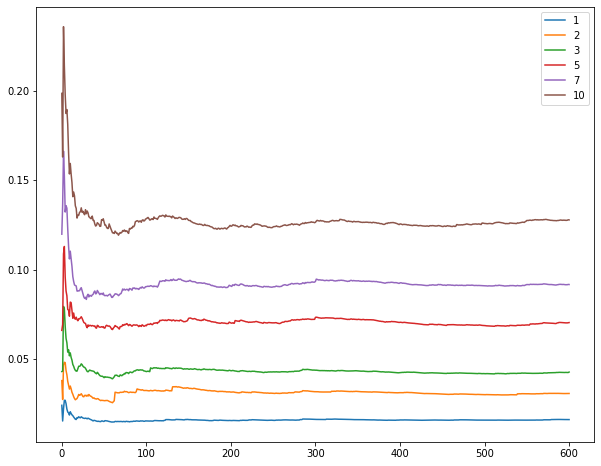

FINAL LOSS (forecast=zero-order, time_horizon=10)
1 : 0.01657834331428631
2 : 0.03089560246913464
3 : 0.043220766718707136
5 : 0.07049417297902587
7 : 0.09232218722006799
10 : 0.12837841070619463


In [545]:
transformer10 = torch.load("models/transformer10/best.ckpt")
all_loss = computeFinalLoss(transformer10, test_symbols, 10, [1, 2, 3, 5, 7, 10])

#### Time Horizon = 100, Test Horizons = (1, 5, 10, 25, 50, 75, 100)

In [565]:
transformer100 = TransformerModel(100, 7, 128, 8, 128, 4)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(transformer100))

1679399


In [566]:
train_losses = list()
val_losses = {i: list() for i in [1, 5, 10, 25, 50, 75, 100]}
best_val = [np.inf]

In [567]:
optimizer = optim.Adam(transformer100.parameters(), lr = 0.0005)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 2.7221474997811854
5 : 0.17226592317956982
10 : 3.8967380381943184
25 : 0.47318758058035465
50 : 2.651161732008684
75 : 0.7552070420717505
100 : 10.48581235438983
saved checkpoint: 21.156520170205695


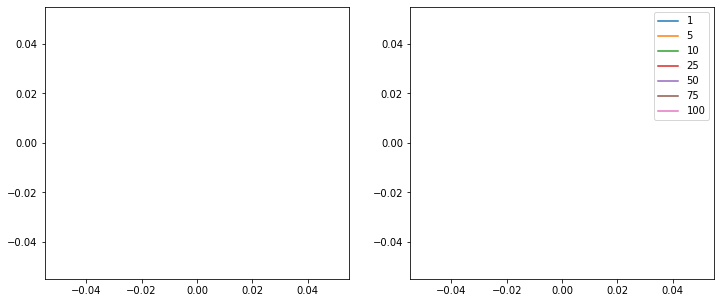

Step: 0... Loss: 4.670116...
Step: 10... Loss: 9.431326...
Step: 20... Loss: 4.204577...
Step: 30... Loss: 3.639221...
Step: 40... Loss: 3.540383...
Step: 50... Loss: 3.282782...
Step: 60... Loss: 3.366613...
Step: 70... Loss: 3.196095...
Step: 80... Loss: 2.886972...
Step: 90... Loss: 3.042656...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.02423519919579591
5 : 0.06174235065046876
10 : 0.12377392560541907
25 : 0.21448787903029057
50 : 0.30322480500515714
75 : 0.44282452388171595
100 : 0.5348843938634242
saved checkpoint: 1.7051730772322715


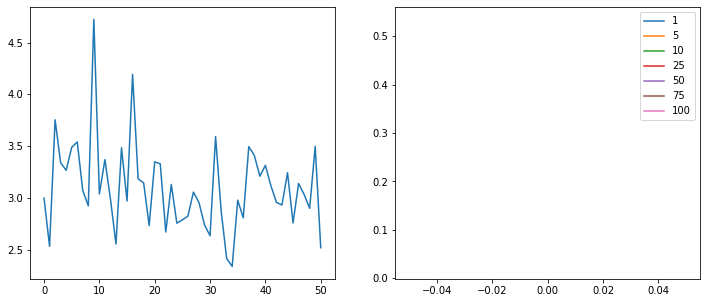

Step: 100... Loss: 3.008251...
Step: 110... Loss: 2.829517...
Step: 120... Loss: 3.086535...
Step: 130... Loss: 2.797474...
Step: 140... Loss: 2.656387...
Step: 150... Loss: 2.983213...
Step: 160... Loss: 2.929155...
Step: 170... Loss: 2.986060...
Step: 180... Loss: 2.938135...
Step: 190... Loss: 2.905627...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.02765165287166638
5 : 0.06459195520062769
10 : 0.10398540884506607
25 : 0.1920061942532208
50 : 0.34439975826064473
75 : 0.47104139610603624
100 : 0.5354771785171728


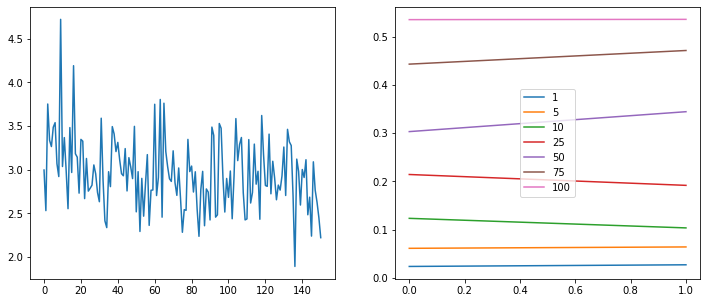

Step: 200... Loss: 2.658747...
Step: 210... Loss: 3.067542...
Step: 220... Loss: 2.495887...
Step: 230... Loss: 2.965438...
Step: 240... Loss: 2.961064...
Step: 250... Loss: 2.953916...
Step: 260... Loss: 3.024203...
Step: 270... Loss: 2.618485...
Step: 280... Loss: 2.968768...
Step: 290... Loss: 2.663764...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.020063490722261608
5 : 0.09380683043488754
10 : 0.09791923342777883
25 : 0.18013383171461367
50 : 0.2943051124400698
75 : 0.43951408819388016
100 : 0.6257099911558599


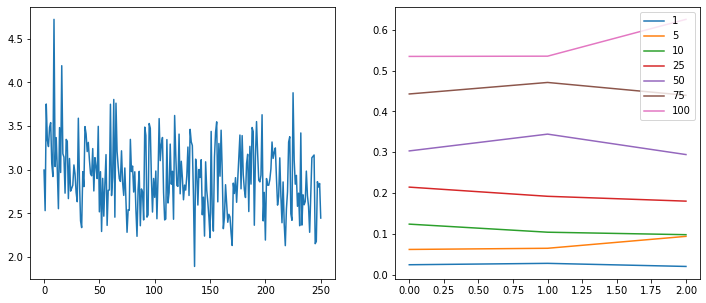

Step: 300... Loss: 2.744985...
Step: 310... Loss: 3.055748...
Step: 320... Loss: 2.793487...
Step: 330... Loss: 2.824399...
Step: 340... Loss: 2.852560...
Step: 350... Loss: 2.893319...
Step: 360... Loss: 2.754013...
Step: 370... Loss: 3.111218...
Step: 380... Loss: 2.636949...
Step: 390... Loss: 2.891920...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.017162543253372724
5 : 0.06366802483237516
10 : 0.10661777758696109
25 : 0.19524302379123534
50 : 0.28421904515502633
75 : 0.4021598986442468
100 : 0.51519529111659
saved checkpoint: 1.5842656043798073


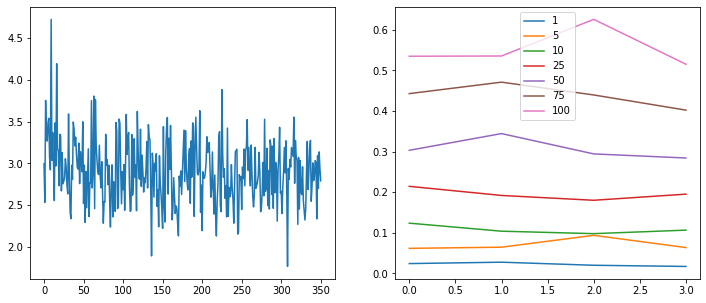

Step: 400... Loss: 2.866480...
Step: 410... Loss: 2.890360...
Step: 420... Loss: 2.759744...
Step: 430... Loss: 2.676268...
Step: 440... Loss: 2.938441...
Step: 450... Loss: 2.682048...
Step: 460... Loss: 2.810160...
Step: 470... Loss: 2.706843...
Step: 480... Loss: 2.776734...
Step: 490... Loss: 2.784724...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.016560296183135228
5 : 0.05505015608717952
10 : 0.09165129830075482
25 : 0.1827648907868094
50 : 0.30582765670542916
75 : 0.4240615470321379
100 : 0.4900507861320893
saved checkpoint: 1.5659666312275353


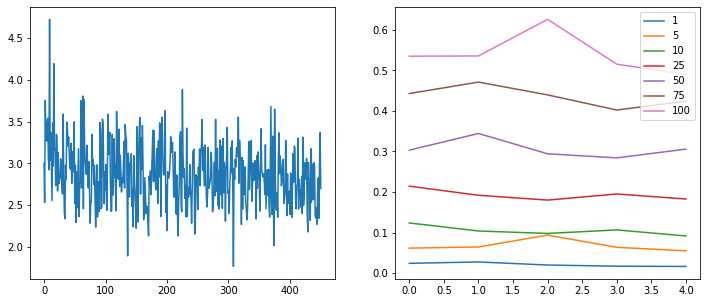

Step: 500... Loss: 2.638669...
Step: 510... Loss: 2.820364...
Step: 520... Loss: 2.419369...
Step: 530... Loss: 2.454535...
Step: 540... Loss: 2.616238...
Step: 550... Loss: 2.653781...
Step: 560... Loss: 2.622460...
Step: 570... Loss: 2.718544...
Step: 580... Loss: 2.664789...
Step: 590... Loss: 2.815082...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.019241525993781594
5 : 0.0647610879773071
10 : 0.11475813676056575
25 : 0.18739931749837047
50 : 0.3063997753320692
75 : 0.41827700205553375
100 : 0.516193365981147


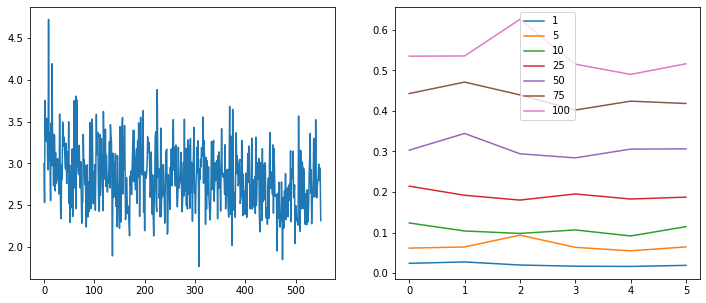

Step: 600... Loss: 2.750465...
Step: 610... Loss: 2.791241...
Step: 620... Loss: 2.683220...
Step: 630... Loss: 2.736647...
Step: 640... Loss: 2.704577...
Step: 650... Loss: 2.774154...
Step: 660... Loss: 2.642919...
Step: 670... Loss: 2.540840...
Step: 680... Loss: 2.591806...
Step: 690... Loss: 2.646948...


  0%|          | 0/300 [00:00<?, ?it/s]

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.013868146618123169
5 : 0.055320701578666975
10 : 0.1005709864646897
25 : 0.1813573565722388
50 : 0.29179574117156526
75 : 0.39975849065213725
100 : 0.5239227165531365


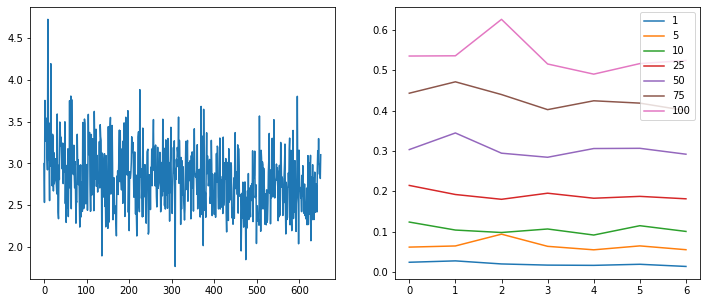

Step: 700... Loss: 2.953364...
Step: 710... Loss: 2.631951...
Step: 720... Loss: 2.880412...


KeyboardInterrupt: 

In [568]:
trainModel(transformer100, train_losses, val_losses, best_val, optimizer, 100, [1, 5, 10, 25, 50, 75, 100], 100, "transformer100")

  0%|          | 0/700 [00:00<?, ?it/s]

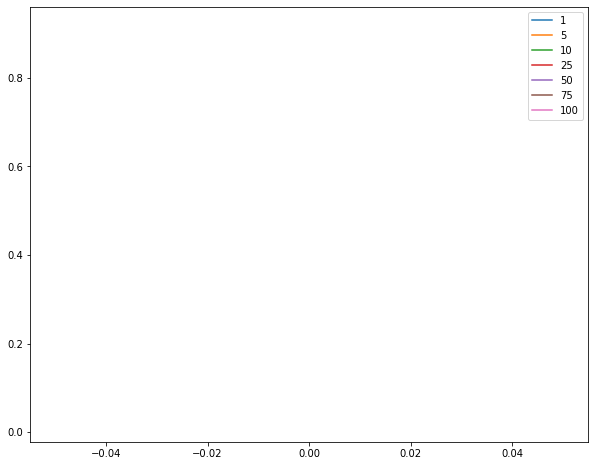

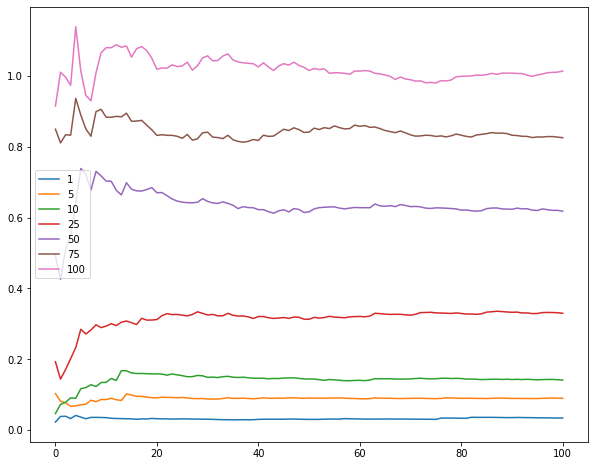

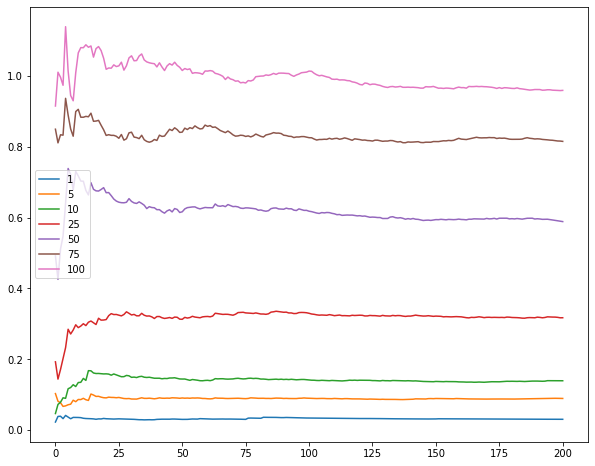

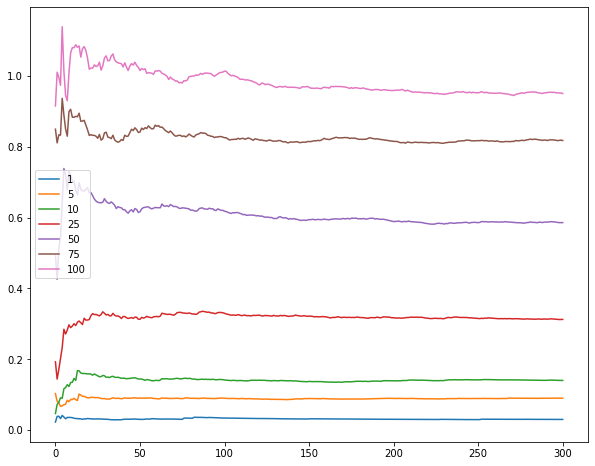

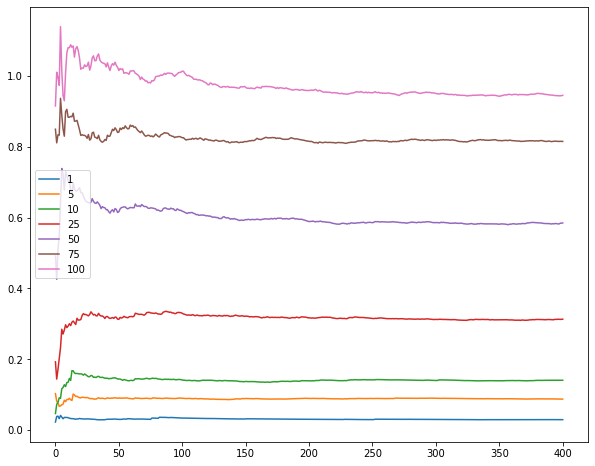

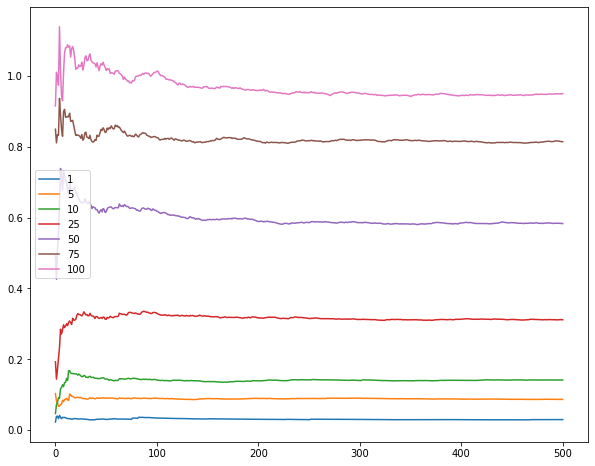

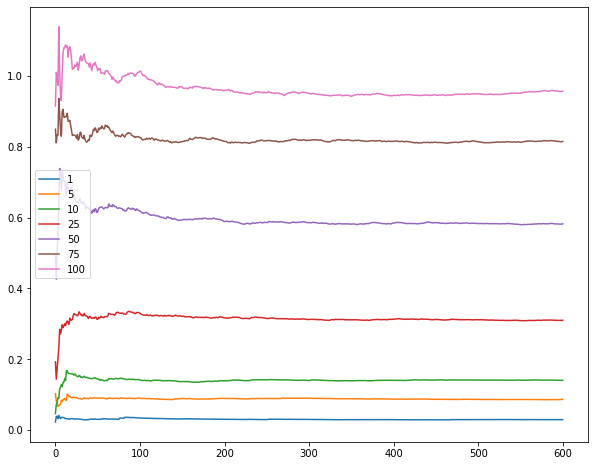

FINAL LOSS (forecast=zero-order, time_horizon=100)
1 : 0.029532524205767487
5 : 0.08620612549909405
10 : 0.1398954586028154
25 : 0.3103577005853399
50 : 0.5807109948495884
75 : 0.8148323653540126
100 : 0.9613556430538175


In [569]:
transformer100 = torch.load("models/transformer100/best.ckpt")
all_loss = computeFinalLoss(transformer100, test_symbols, 100, [1, 5, 10, 25, 50, 75, 100])